# 🎯 **Classificação de Textos com Representações Vetoriais**
## *Demonstração Prática - PPGEP9002 - 2025.2*

---

### 📋 **Objetivo**
Demonstrar técnicas de classificação de textos utilizando diferentes representações vetoriais (embeddings) e algoritmos de machine learning.

### 🎯 **Conceitos Abordados**
- Pré-processamento de textos em português
- Representações vetoriais: TF-IDF, BERT, Sentence Transformers, OpenAI
- Classificadores: Naive Bayes, SVM, Random Forest, Logistic Regression, KNN
- Avaliação e visualização de resultados
- Persistência de dados com SQLite

### 🔧 **Atualizações da Versão**
- **Substituição**: Gensim → Sentence Transformers para melhor compatibilidade
- **Melhorias**: Código mais organizado e didático
- **Compatibilidade**: Python 3.12+ otimizado

### 📊 **Dataset**
- **Fonte**: Base_dados_textos_6_classes.xlsx
- **Classes**: 6 categorias de textos em português
- **Tamanho**: ~315 documentos

---


## 1. 🗄️ **Inicialização do Sistema e Banco de Dados**

**Por que começar com o banco?** A persistência de dados é fundamental para:
- Evitar reprocessamento de embeddings caros (BERT, OpenAI)
- Economizar custos com APIs
- Permitir análise histórica e comparação de experimentos
- Garantir reprodutibilidade dos resultados


In [10]:
# =============================================================================
# INICIALIZAÇÃO DO SISTEMA E BANCO DE DADOS
# =============================================================================

import os
import sqlite3
from pathlib import Path

# Criar pasta database se não existir
database_dir = Path("database")
database_dir.mkdir(exist_ok=True)

# Inicializar banco SQLite
db_path = database_dir / "text_classification.db"
print(f"🗄️  Inicializando banco SQLite: {db_path}")

# Conectar ao banco
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Criar tabelas
print("📋 Criando estrutura do banco de dados...")

# Tabela para dados do corpus
cursor.execute('''
CREATE TABLE IF NOT EXISTS corpus_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    texto_original TEXT,
    texto_expandido TEXT,
    classe INTEGER,
    categoria TEXT,
    texto_limpo TEXT,
    texto_sem_stopwords TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

# Tabelas para embeddings
for embedding_type in ['tfidf', 'bow', 'bert', 'word2vec', 'openai']:
    cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS embeddings_{embedding_type} (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        text_id INTEGER,
        embedding_data BLOB,
        metadata TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        FOREIGN KEY (text_id) REFERENCES corpus_data (id)
    )
    ''')

# Tabela para resultados de classificação
cursor.execute('''
CREATE TABLE IF NOT EXISTS classification_results (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    embedding_type TEXT,
    classifier_name TEXT,
    accuracy REAL,
    precision_score REAL,
    recall_score REAL,
    f1_score REAL,
    test_size REAL,
    random_state INTEGER,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

# Tabela para metadados de experimentos
cursor.execute('''
CREATE TABLE IF NOT EXISTS experiment_metadata (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    experiment_name TEXT,
    description TEXT,
    parameters TEXT,
    results_summary TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

# Commit das tabelas
conn.commit()

print("✅ Banco de dados inicializado com sucesso!")
print(f"📊 Tabelas criadas: corpus_data, embeddings_*, classification_results, experiment_metadata")

# Classe para gerenciar o banco
class DatabaseManager:
    def __init__(self, conn):
        self.conn = conn
    
    def save_corpus_data(self, df):
        """Salva dados do corpus no banco"""
        cursor = self.conn.cursor()
        
        # Limpar dados existentes
        cursor.execute("DELETE FROM corpus_data")
        
        # Inserir novos dados
        for _, row in df.iterrows():
            cursor.execute('''
                INSERT INTO corpus_data (texto_original, texto_expandido, classe, categoria, texto_limpo, texto_sem_stopwords)
                VALUES (?, ?, ?, ?, ?, ?)
            ''', (
                row.get('Texto Original', ''),
                row.get('Texto Expandido', ''),
                row.get('Classe', 0),
                row.get('Categoria', ''),
                row.get('texto_limpo', ''),
                row.get('texto_sem_stopwords', '')
            ))
        
        self.conn.commit()
        print(f"💾 {len(df)} registros salvos na tabela corpus_data")
    
    def save_embeddings(self, embedding_type, embeddings, metadata):
        """Salva embeddings no banco"""
        cursor = self.conn.cursor()
        
        # Limpar embeddings existentes deste tipo
        cursor.execute(f"DELETE FROM embeddings_{embedding_type}")
        
        # Converter embeddings para bytes
        import pickle
        
        # Converter sparse matrix para dense se necessário
        if hasattr(embeddings, 'toarray'):
            embeddings_dense = embeddings.toarray()
        else:
            embeddings_dense = embeddings
            
        embeddings_bytes = pickle.dumps(embeddings_dense)
        metadata_json = str(metadata)
        
        # Inserir embeddings
        for i, embedding in enumerate(embeddings_dense):
            cursor.execute(f'''
                INSERT INTO embeddings_{embedding_type} (text_id, embedding_data, metadata)
                VALUES (?, ?, ?)
            ''', (i+1, embeddings_bytes, metadata_json))
        
        self.conn.commit()
        print(f"💾 Embeddings {embedding_type} salvos: {len(embeddings_dense)} registros")
    
    def save_classification_results(self, results):
        """Salva resultados de classificação no banco"""
        cursor = self.conn.cursor()
        
        # Limpar resultados existentes
        cursor.execute("DELETE FROM classification_results")
        
        # Inserir novos resultados
        for result in results:
            cursor.execute('''
                INSERT INTO classification_results (embedding_type, classifier_name, accuracy, precision_score, recall_score, f1_score, test_size, random_state)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                result['embedding_type'],
                result['classifier_name'],
                result['accuracy'],
                result['precision'],
                result['recall'],
                result['f1'],
                result.get('test_size', 0.2),
                result.get('random_state', 42)
            ))
        
        self.conn.commit()
        print(f"💾 {len(results)} resultados de classificação salvos")
    
    def validate_data_integrity(self):
        """Valida integridade dos dados salvos no banco"""
        print("\n🔍 VALIDAÇÃO DE INTEGRIDADE DOS DADOS")
        print("=" * 50)
        
        cursor = self.conn.cursor()
        
        # Verificar tabelas de embeddings
        embedding_tables = ['tfidf', 'bow', 'bert', 'sentence_transformer', 'openai']
        
        for table in embedding_tables:
            try:
                cursor.execute(f"SELECT COUNT(*) FROM embeddings_{table}")
                count = cursor.fetchone()[0]
                
                if count > 0:
                    # Verificar se os dados são válidos
                    cursor.execute(f"SELECT metadata FROM embeddings_{table} LIMIT 1")
                    metadata = cursor.fetchone()
                    if metadata:
                        print(f"✅ {table.upper()}: {count} registros (dados válidos)")
                    else:
                        print(f"⚠️  {table.upper()}: {count} registros (metadados ausentes)")
                else:
                    print(f"❌ {table.upper()}: 0 registros")
            except Exception as e:
                print(f"❌ {table.upper()}: Erro - {e}")
        
        # Verificar corpus_data
        try:
            cursor.execute("SELECT COUNT(*) FROM corpus_data")
            count = cursor.fetchone()[0]
            print(f"✅ CORPUS_DATA: {count} registros")
        except Exception as e:
            print(f"❌ CORPUS_DATA: Erro - {e}")
        
        # Verificar classification_results
        try:
            cursor.execute("SELECT COUNT(*) FROM classification_results")
            count = cursor.fetchone()[0]
            print(f"✅ CLASSIFICATION_RESULTS: {count} registros")
        except Exception as e:
            print(f"❌ CLASSIFICATION_RESULTS: Erro - {e}")
        
        print("=" * 50)

# Criar instância do gerenciador
db_manager = DatabaseManager(conn)
print("🎯 DatabaseManager criado e pronto para uso!")


🗄️  Inicializando banco SQLite: database/text_classification.db
📋 Criando estrutura do banco de dados...
✅ Banco de dados inicializado com sucesso!
📊 Tabelas criadas: corpus_data, embeddings_*, classification_results, experiment_metadata
🎯 DatabaseManager criado e pronto para uso!


## 2. 📊 **Processamento e Limpeza de Dados**

**Por que limpar os dados?** A qualidade dos dados é crucial para o sucesso de qualquer projeto de ML. Dados "sujos" podem reduzir performance, introduzir viés e causar erros.

**Etapas implementadas:**
- Remoção de linhas/colunas vazias
- Padronização de strings
- Tratamento de valores nulos
- Remoção de duplicatas
- Filtro de completude (50% mínimo)
- Validação de campos críticos


In [11]:
# =============================================================================
# PROCESSAMENTO UNIFICADO: EXCEL → CSV LIMPO + BANCO SQLITE
# =============================================================================

import pandas as pd
import numpy as np
import os
from pathlib import Path

def process_excel_to_csv(excel_path, csv_output_path=None):
    """
    Processa arquivo Excel, faz limpeza e gera CSV limpo
    """
    print("🔄 PROCESSAMENTO UNIFICADO: EXCEL → CSV")
    print("=" * 50)
    
    try:
        # 1. Carregar arquivo Excel
        print(f"📂 Carregando: {excel_path}")
        df = pd.read_excel(excel_path, engine='openpyxl')
        print(f"✅ Dataset original carregado: {df.shape}")
        
        # Preservar dados originais para comparação
        df_original = df.copy()
        
        # 2. Análise inicial
        print(f"\n📊 ANÁLISE INICIAL:")
        print(f"Colunas: {list(df.columns)}")
        print(f"Tipos: {dict(df.dtypes)}")
        
        # Valores nulos
        print(f"\n❓ Valores nulos por coluna:")
        for col in df.columns:
            nulls = df[col].isnull().sum()
            percentage = (nulls / len(df)) * 100
            print(f"  {col}: {nulls} ({percentage:.1f}%)")
        
        # 3. Limpeza de dados
        print(f"\n🧹 INICIANDO LIMPEZA:")
        
        # Remover linhas completamente vazias
        rows_before = len(df)
        df = df.dropna(how='all')
        print(f"Linhas vazias removidas: {rows_before - len(df)}")
        
        # Remover colunas completamente vazias
        cols_before = len(df.columns)
        df = df.dropna(axis=1, how='all')
        print(f"Colunas vazias removidas: {cols_before - len(df.columns)}")
        
        # Limpar strings
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].astype(str).str.strip()
                df[col] = df[col].replace(['', 'nan', 'None', 'null'], np.nan)
        
        # Remover duplicatas
        duplicates_before = df.duplicated().sum()
        df = df.drop_duplicates()
        print(f"Duplicatas removidas: {duplicates_before}")
        
        # Remover linhas com muitos campos faltantes (threshold: 50%)
        completeness = (df.notna().sum(axis=1) / len(df.columns)) * 100
        threshold = 50
        lines_to_remove = completeness < threshold
        if lines_to_remove.sum() > 0:
            df = df[~lines_to_remove]
            print(f"Linhas com <{threshold}% dados removidas: {lines_to_remove.sum()}")
        
        # Remover linhas onde colunas críticas estão nulas
        critical_cols = [df.columns[0]]  # Primeira coluna como crítica
        for col in critical_cols:
            if col in df.columns:
                rows_before = len(df)
                df = df.dropna(subset=[col])
                print(f"Linhas removidas por {col} nulo: {rows_before - len(df)}")
        
        # 4. Resultado final
        print(f"\n✅ RESULTADO FINAL:")
        print(f"Original: {df_original.shape}")
        print(f"Limpo: {df.shape}")
        print(f"Linhas mantidas: {len(df)} ({len(df)/len(df_original)*100:.1f}%)")
        
        # 5. Salvar CSV
        if csv_output_path is None:
            csv_output_path = excel_path.replace('.xlsx', '_limpo.csv')
        
        df.to_csv(csv_output_path, index=False, encoding='utf-8', sep=',')
        print(f"💾 CSV salvo: {csv_output_path}")
        
        # 6. Análise final de qualidade
        print(f"\n📈 QUALIDADE FINAL:")
        for col in df.columns:
            nulls = df[col].isnull().sum()
            percentage = (nulls / len(df)) * 100 if len(df) > 0 else 0
            print(f"  {col}: {nulls} nulos ({percentage:.1f}%)")
        
        return df, df_original, csv_output_path
        
    except Exception as e:
        print(f"❌ Erro no processamento: {e}")
        return None, None, None

# Executar processamento
caminho_corpus = os.path.join(os.getcwd(), 'corpus')
excel_name = 'Base_dados_textos_6_classes.xlsx'
excel_path = os.path.join(caminho_corpus, excel_name)
csv_path = os.path.join(caminho_corpus, 'Base_dados_textos_6_classes_limpo.csv')

print("🚀 Iniciando processamento...")
df, df_original, csv_salvo = process_excel_to_csv(excel_path, csv_path)

if df is not None:
    print(f"\n📋 PRIMEIRAS 5 LINHAS DO DATASET LIMPO:")
    display(df.head())
    
    print(f"\n📊 INFORMAÇÕES DO DATASET FINAL:")
    print(f"Forma: {df.shape}")
    print(f"Colunas: {list(df.columns)}")
    
    # Verificar se tem as colunas esperadas para classificação
    expected_cols = ['Texto Original', 'Classe']
    missing_cols = [col for col in expected_cols if col not in df.columns]
    if missing_cols:
        print(f"⚠️  Colunas esperadas não encontradas: {missing_cols}")
        print(f"Colunas disponíveis: {list(df.columns)}")
    else:
        print(f"✅ Todas as colunas necessárias encontradas!")
    
    # Salvar dados no banco SQLite
    try:
        db_manager.save_corpus_data(df)
        print(f"💾 Dados salvos no banco SQLite com sucesso!")
    except Exception as e:
        print(f"❌ Erro ao salvar no banco: {e}")
        
else:
    print("❌ Falha no processamento do dataset")


🚀 Iniciando processamento...
🔄 PROCESSAMENTO UNIFICADO: EXCEL → CSV
📂 Carregando: /Users/ivanvarella/Documents/Dados/9 - Mestrado/1 - Disciplinas 2025/2025.2/PPGEP9002 - INTELIGÊNCIA COMPUTACIONAL PARA ENGENHARIA DE PRODUÇÃO - T01/1 - Extra - Professor/Pesquisa Aula - 17.09.25/codes/corpus/Base_dados_textos_6_classes.xlsx
✅ Dataset original carregado: (315, 4)

📊 ANÁLISE INICIAL:
Colunas: ['Texto Original', 'Texto Expandido', 'Classe', 'Categoria']
Tipos: {'Texto Original': dtype('O'), 'Texto Expandido': dtype('O'), 'Classe': dtype('int64'), 'Categoria': dtype('O')}

❓ Valores nulos por coluna:
  Texto Original: 0 (0.0%)
  Texto Expandido: 0 (0.0%)
  Classe: 0 (0.0%)
  Categoria: 0 (0.0%)

🧹 INICIANDO LIMPEZA:
Linhas vazias removidas: 0
Colunas vazias removidas: 0
Duplicatas removidas: 0
Linhas removidas por Texto Original nulo: 0

✅ RESULTADO FINAL:
Original: (315, 4)
Limpo: (315, 4)
Linhas mantidas: 315 (100.0%)
💾 CSV salvo: /Users/ivanvarella/Documents/Dados/9 - Mestrado/1 - Disc

,Texto Original,Texto Expandido,Classe,Categoria
0,Desenvolvimento de criptomoedas e blockchain: ...,O Brasil emerge como um polo de inovação no me...,0,Economia
1,Economia colaborativa: plataformas que revoluc...,Plataformas de economia colaborativa estão red...,0,Economia
2,Economia criativa no audiovisual: potencial de...,O setor audiovisual brasileiro apresenta cresc...,0,Economia
3,Economia do conhecimento: investimentos em edu...,A economia do conhecimento se torna estratégic...,0,Economia
4,Indústria 4.0 no Brasil: transformação digital...,A Indústria 4.0 representa uma revolução tecno...,0,Economia



📊 INFORMAÇÕES DO DATASET FINAL:
Forma: (315, 4)
Colunas: ['Texto Original', 'Texto Expandido', 'Classe', 'Categoria']
✅ Todas as colunas necessárias encontradas!
💾 315 registros salvos na tabela corpus_data
💾 Dados salvos no banco SQLite com sucesso!


## 3. 📚 **Importação de Bibliotecas**

**Stack utilizada:** pandas, numpy, scikit-learn, transformers, nltk, sentence-transformers, matplotlib, seaborn, plotly, openai, langchain, sqlite3

O código verifica automaticamente quais bibliotecas estão disponíveis e adapta o processamento accordingly.

**🔧 Atualização Importante:** Substituímos `gensim` por `sentence-transformers` para melhor compatibilidade e performance com Python 3.12+.


In [12]:
# =============================================================================
# IMPORTAÇÃO DE BIBLIOTECAS E VERIFICAÇÃO DE DISPONIBILIDADE
# =============================================================================

# 📚 BIBLIOTECAS BÁSICAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# 🔧 CONFIGURAÇÕES DE AMBIENTE
# Corrigir warning do tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 🤖 MACHINE LEARNING
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 🔤 PROCESSAMENTO DE LINGUAGEM NATURAL
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
import re

# 🔍 VERIFICAÇÃO DE DISPONIBILIDADE DE BIBLIOTECAS AVANÇADAS
TRANSFORMERS_AVAILABLE = False
SENTENCE_TRANSFORMERS_AVAILABLE = False
OPENAI_AVAILABLE = False
LANGCHAIN_AVAILABLE = False

print("🔍 Verificando disponibilidade de bibliotecas...")
print("=" * 50)

# Transformers (BERT)
try:
    import transformers
    from transformers import AutoTokenizer, AutoModel
    import torch
    TRANSFORMERS_AVAILABLE = True
    print("✅ Transformers (BERT) disponível")
except ImportError:
    print("❌ Transformers não disponível. Instale com: uv add transformers torch")

# Sentence Transformers (substituto do Gensim)
try:
    from sentence_transformers import SentenceTransformer
    SENTENCE_TRANSFORMERS_AVAILABLE = True
    print("✅ Sentence Transformers disponível")
except ImportError:
    print("❌ Sentence Transformers não disponível. Instale com: uv add sentence-transformers")

# OpenAI
try:
    import openai
    OPENAI_AVAILABLE = True
    print("✅ OpenAI disponível")
except ImportError:
    print("❌ OpenAI não disponível. Instale com: uv add openai")

# LangChain
try:
    from langchain_openai import OpenAIEmbeddings
    LANGCHAIN_AVAILABLE = True
    print("✅ LangChain disponível")
except ImportError:
    try:
        from langchain.embeddings import OpenAIEmbeddings
        LANGCHAIN_AVAILABLE = True
        print("✅ LangChain disponível")
    except ImportError:
        print("❌ LangChain não disponível. Instale com: uv add langchain langchain-openai")

# Tiktoken para cálculo preciso de tokens
try:
    import tiktoken
    TIKTOKEN_AVAILABLE = True
    print("✅ Tiktoken disponível")
except ImportError:
    TIKTOKEN_AVAILABLE = False
    print("❌ Tiktoken não disponível. Instale com: uv add tiktoken")

# 🎨 CONFIGURAÇÕES DE VISUALIZAÇÃO
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("\n✅ Bibliotecas básicas importadas com sucesso!")

# =============================================================================
# CONFIGURAÇÃO DO MODELO DE EMBEDDINGS PRINCIPAL
# =============================================================================

print("\n🚀 CONFIGURANDO MODELO DE EMBEDDINGS PRINCIPAL")
print("=" * 60)

# Configurar modelo de embeddings baseado na disponibilidade
if SENTENCE_TRANSFORMERS_AVAILABLE:
    # 🎯 USAR SENTENCE TRANSFORMERS (RECOMENDADO)
    print("📥 Carregando modelo Sentence Transformers para português...")
    print("   Modelo: paraphrase-multilingual-mpnet-base-v2")
    print("   Dimensões: 768")
    print("   Idiomas: Multilíngue (incluindo português)")
    
    sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
    print("✅ Modelo Sentence Transformers carregado com sucesso!")
    
    def get_text_embeddings(texts):
        """
        🎯 Gerar embeddings usando Sentence Transformers
        
        Args:
            texts (list): Lista de textos para processar
            
        Returns:
            numpy.ndarray: Array de embeddings com shape (n_texts, 768)
        """
        print(f"🔄 Gerando embeddings para {len(texts)} textos...")
        embeddings = sentence_model.encode(texts, show_progress_bar=True)
        print(f"✅ Embeddings gerados: {embeddings.shape}")
        return embeddings
        
elif TRANSFORMERS_AVAILABLE:
    # 🔄 FALLBACK PARA TRANSFORMERS (BERT)
    print("📥 Usando BERT como alternativa...")
    
    def get_text_embeddings(texts):
        """Gerar embeddings usando BERT"""
        print("⚠️  Implementação BERT simplificada - use Sentence Transformers para melhor performance")
        return None
        
else:
    # 📊 ÚLTIMO RECURSO: TF-IDF
    print("📥 Usando TF-IDF como método de vetorização...")
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    
    def get_text_embeddings(texts):
        """Gerar embeddings usando TF-IDF"""
        return vectorizer.fit_transform(texts).toarray()

# 📊 RESUMO FINAL DE DISPONIBILIDADE
print("\n" + "="*60)
print("📊 RESUMO DE BIBLIOTECAS DISPONÍVEIS:")
print("="*60)
print(f"🤖 Transformers (BERT): {'✅' if TRANSFORMERS_AVAILABLE else '❌'}")
print(f"🎯 Sentence Transformers: {'✅' if SENTENCE_TRANSFORMERS_AVAILABLE else '❌'}")
print(f"🔮 OpenAI: {'✅' if OPENAI_AVAILABLE else '❌'}")
print(f"🔗 LangChain: {'✅' if LANGCHAIN_AVAILABLE else '❌'}")
print("="*60)

# 🎯 MODELO PRINCIPAL SELECIONADO
if SENTENCE_TRANSFORMERS_AVAILABLE:
    print("🎯 Modelo principal: Sentence Transformers")
elif TRANSFORMERS_AVAILABLE:
    print("🎯 Modelo principal: BERT (Transformers)")
else:
    print("🎯 Modelo principal: TF-IDF")
print("="*60)

🔍 Verificando disponibilidade de bibliotecas...
✅ Transformers (BERT) disponível
✅ Sentence Transformers disponível
✅ OpenAI disponível
✅ LangChain disponível
✅ Tiktoken disponível

✅ Bibliotecas básicas importadas com sucesso!

🚀 CONFIGURANDO MODELO DE EMBEDDINGS PRINCIPAL
📥 Carregando modelo Sentence Transformers para português...
   Modelo: paraphrase-multilingual-mpnet-base-v2
   Dimensões: 768
   Idiomas: Multilíngue (incluindo português)
✅ Modelo Sentence Transformers carregado com sucesso!

📊 RESUMO DE BIBLIOTECAS DISPONÍVEIS:
🤖 Transformers (BERT): ✅
🎯 Sentence Transformers: ✅
🔮 OpenAI: ✅
🔗 LangChain: ✅
🎯 Modelo principal: Sentence Transformers


## 4. 🔧 **Pré-processamento de Textos**

**Por que pré-processar?** É essencial para transformar textos brutos em dados adequados para ML:
- Padronização e redução de dimensionalidade
- Melhoria da qualidade focando no conteúdo semântico
- Compatibilidade com algoritmos específicos

**Etapas implementadas:**
- Limpeza básica (minúsculas, pontuação, números)
- Tokenização e remoção de stopwords em português
- Stemming com algoritmo RSLP específico para português brasileiro
- Geração de duas versões: texto_limpo e texto_sem_stopwords


In [13]:
# =============================================================================
# PRÉ-PROCESSAMENTO DE TEXTOS EM PORTUGUÊS
# =============================================================================

# Baixar recursos do NLTK se necessário
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/rslp')
except LookupError:
    nltk.download('rslp')

class TextPreprocessor:
    """
    Classe para pré-processamento de textos em português
    """
    def __init__(self):
        # Stopwords em português
        self.stopwords_pt = set(stopwords.words('portuguese'))
        
        # Adicionar stopwords customizadas
        self.stopwords_pt.update([
            'que', 'com', 'para', 'por', 'uma', 'dos', 'das', 'pelo', 'pela',
            'são', 'ser', 'ter', 'está', 'estão', 'foi', 'foram', 'tem',
            'têm', 'pode', 'podem', 'deve', 'devem', 'vai', 'vão', 'vem',
            'vêm', 'faz', 'fazem', 'fez', 'fizeram', 'diz', 'dizem', 'disse',
            'disseram', 'vê', 'vêem', 'viu', 'viram', 'sabe', 'sabem', 'soube',
            'souberam', 'quer', 'querem', 'quis', 'quiseram', 'pode', 'podem',
            'pôde', 'puderam', 'deve', 'devem', 'deveria', 'deveriam', 'pode',
            'podem', 'poderia', 'poderiam', 'tem', 'têm', 'tinha', 'tinham',
            'teria', 'teriam', 'está', 'estão', 'estava', 'estavam', 'estará',
            'estarão', 'foi', 'foram', 'era', 'eram', 'será', 'serão', 'há',
            'havia', 'haviam', 'haverá', 'haverão', 'faz', 'fazem', 'fazia',
            'faziam', 'fará', 'farão', 'diz', 'dizem', 'dizia', 'diziam',
            'dirá', 'dirão', 'vê', 'vêem', 'via', 'viam', 'verá', 'verão'
        ])
        
        # Stemmer RSLP para português
        self.stemmer = RSLPStemmer()
    
    def clean_text(self, text):
        """
        Limpeza básica do texto
        """
        if pd.isna(text) or text == '':
            return ''
        
        # Converter para string
        text = str(text)
        
        # Converter para minúsculas
        text = text.lower()
        
        # Remover pontuação e caracteres especiais
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remover números
        text = re.sub(r'\d+', '', text)
        
        # Remover espaços extras
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def remove_stopwords(self, text):
        """
        Remove stopwords do texto
        """
        if not text:
            return ''
        
        # Tokenizar
        tokens = word_tokenize(text, language='portuguese')
        
        # Remover stopwords
        tokens = [token for token in tokens if token not in self.stopwords_pt]
        
        # Juntar tokens
        return ' '.join(tokens)
    
    def stem_text(self, text):
        """
        Aplica stemming ao texto
        """
        if not text:
            return ''
        
        # Tokenizar
        tokens = word_tokenize(text, language='portuguese')
        
        # Aplicar stemming
        tokens = [self.stemmer.stem(token) for token in tokens]
        
        # Juntar tokens
        return ' '.join(tokens)
    
    def preprocess(self, text, remove_stopwords=True, apply_stemming=True):
        """
        Pré-processamento completo do texto
        """
        # Limpeza básica
        text = self.clean_text(text)
        
        if remove_stopwords:
            text = self.remove_stopwords(text)
        
        if apply_stemming:
            text = self.stem_text(text)
        
        return text

# Instanciar preprocessador
preprocessor = TextPreprocessor()

# Aplicar pré-processamento aos dados
if 'df' in locals() and df is not None:
    print("🔄 Aplicando pré-processamento aos textos...")
    
    # Pré-processamento básico (apenas limpeza)
    df['texto_limpo'] = df['Texto Original'].apply(
        lambda x: preprocessor.preprocess(x, remove_stopwords=False, apply_stemming=False)
    )
    
    # Pré-processamento completo (limpeza + stopwords + stemming)
    df['texto_sem_stopwords'] = df['Texto Original'].apply(
        lambda x: preprocessor.preprocess(x, remove_stopwords=True, apply_stemming=True)
    )
    
    print("✅ Pré-processamento concluído!")
    
    # Mostrar exemplos
    print("\n📋 EXEMPLOS DE PRÉ-PROCESSAMENTO:")
    for i in range(3):
        print(f"\n--- Exemplo {i+1} ---")
        print(f"Original: {df['Texto Original'].iloc[i][:100]}...")
        print(f"Limpo: {df['texto_limpo'].iloc[i][:100]}...")
        print(f"Sem stopwords: {df['texto_sem_stopwords'].iloc[i][:100]}...")
    
    # Atualizar dados no banco
    try:
        db_manager.save_corpus_data(df)
        print("💾 Dados atualizados no banco SQLite!")
    except Exception as e:
        print(f"❌ Erro ao atualizar banco: {e}")
        
else:
    print("⚠️  Dataset não disponível para pré-processamento")


🔄 Aplicando pré-processamento aos textos...
✅ Pré-processamento concluído!

📋 EXEMPLOS DE PRÉ-PROCESSAMENTO:

--- Exemplo 1 ---
Original: Desenvolvimento de criptomoedas e blockchain: inovação financeira brasileira...
Limpo: desenvolvimento de criptomoedas e blockchain inovação financeira brasileira...
Sem stopwords: desenvolv criptomoed blockchain inov financ brasil...

--- Exemplo 2 ---
Original: Economia colaborativa: plataformas que revolucionam setores de transporte, hospedagem e serviços...
Limpo: economia colaborativa plataformas que revolucionam setores de transporte hospedagem e serviços...
Sem stopwords: econom colabor plataform revolucion set transport hosped serviç...

--- Exemplo 3 ---
Original: Economia criativa no audiovisual: potencial de crescimento da produção brasileira de séries e filmes...
Limpo: economia criativa no audiovisual potencial de crescimento da produção brasileira de séries e filmes...
Sem stopwords: econom cria audiovis potenc cresc produç brasil séri 

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/ivanvarella/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## 5. 🎯 **Geração de Representações Vetoriais (Embeddings)**

**O que são embeddings?** Representações numéricas de textos que capturam informações semânticas e sintáticas.

**Tipos implementados:**
- **TF-IDF**: Pondera palavras pela frequência vs. raridade no corpus
- **Bag of Words**: Conta frequência de cada palavra
- **BERT**: Modelo pré-treinado que captura contexto bidirecional
- **Sentence Transformers**: Modelo moderno que gera embeddings de sentenças completas
- **OpenAI**: Embeddings modernos via API (text-embedding-3-small)

**🔧 Atualização:** Substituímos Word2Vec por Sentence Transformers para melhor compatibilidade e performance.


In [14]:
# =============================================================================
# GERAÇÃO DE REPRESENTAÇÕES VETORIAIS (EMBEDDINGS)
# =============================================================================

def generate_tfidf_embeddings(texts, max_features=5000, ngram_range=(1, 2)):
    """
    📊 Gera embeddings TF-IDF
    
    Args:
        texts (list): Lista de textos pré-processados
        max_features (int): Número máximo de features
        ngram_range (tuple): Range de n-gramas
        
    Returns:
        tuple: (matriz_esparsa, vectorizer)
    """
    print("🔄 Gerando embeddings TF-IDF...")
    
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words=None,  # Já removemos stopwords no pré-processamento
        lowercase=False,  # Já convertemos para minúsculas
        min_df=2,
        max_df=0.95
    )
    
    matrix = vectorizer.fit_transform(texts)
    
    print(f"✅ TF-IDF gerado: {matrix.shape}")
    print(f"📚 Vocabulário: {len(vectorizer.vocabulary_)} termos")
    
    return matrix, vectorizer

def generate_bow_embeddings(texts, max_features=5000, ngram_range=(1, 2)):
    """
    📦 Gera embeddings Bag of Words
    
    Args:
        texts (list): Lista de textos pré-processados
        max_features (int): Número máximo de features
        ngram_range (tuple): Range de n-gramas
        
    Returns:
        tuple: (matriz_esparsa, vectorizer)
    """
    print("🔄 Gerando embeddings Bag of Words...")
    
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words=None,
        lowercase=False,
        min_df=2,
        max_df=0.95
    )
    
    matrix = vectorizer.fit_transform(texts)
    
    print(f"✅ Bag of Words gerado: {matrix.shape}")
    print(f"📚 Vocabulário: {len(vectorizer.vocabulary_)} termos")
    
    return matrix, vectorizer

def generate_bert_embeddings(texts, model_name='neuralmind/bert-base-portuguese-cased'):
    """
    🤖 Gera embeddings BERT (se disponível)
    
    Args:
        texts (list): Lista de textos pré-processados
        model_name (str): Nome do modelo BERT
        
    Returns:
        tuple: (embeddings_array, model_name) ou (None, None)
    """
    if not TRANSFORMERS_AVAILABLE:
        print("❌ Transformers não disponível. Pulando BERT...")
        return None, None
    
    print(f"🔄 Gerando embeddings BERT ({model_name})...")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        
        # Configurar para não treinar
        model.eval()
        
        embeddings = []
        
        for i, text in enumerate(texts):
            if i % 50 == 0:  # Progress indicator
                print(f"   Processando texto {i+1}/{len(texts)}")
            
            # Tokenizar
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            
            # Gerar embeddings
            with torch.no_grad():
                outputs = model(**inputs)
                # Usar o embedding do token [CLS] (primeiro token)
                embedding = outputs.last_hidden_state[:, 0, :].numpy()
                embeddings.append(embedding[0])
        
        embeddings_array = np.array(embeddings)
        
        print(f"✅ BERT embeddings gerados: {embeddings_array.shape}")
        
        return embeddings_array, model_name
        
    except Exception as e:
        print(f"❌ Erro ao gerar BERT embeddings: {e}")
        return None, None

def generate_sentence_transformer_embeddings(texts, model_name='sentence-transformers/paraphrase-multilingual-mpnet-base-v2'):
    """
    🎯 Gera embeddings usando Sentence Transformers (substituto do Word2Vec)
    
    Args:
        texts (list): Lista de textos pré-processados
        model_name (str): Nome do modelo Sentence Transformers
        
    Returns:
        tuple: (embeddings_array, model_name) ou (None, None)
    """
    if not SENTENCE_TRANSFORMERS_AVAILABLE:
        print("❌ Sentence Transformers não disponível. Pulando...")
        return None, None
    
    print(f"🔄 Gerando embeddings Sentence Transformers ({model_name})...")
    
    try:
        # Usar o modelo já carregado ou carregar um novo
        if 'sentence_model' in globals():
            model = sentence_model
        else:
            model = SentenceTransformer(model_name)
        
        # Gerar embeddings
        embeddings = model.encode(texts, show_progress_bar=True)
        
        print(f"✅ Sentence Transformers embeddings gerados: {embeddings.shape}")
        print(f"📊 Dimensões: {embeddings.shape[1]}")
        
        return embeddings, model_name
        
    except Exception as e:
        print(f"❌ Erro ao gerar Sentence Transformers embeddings: {e}")
        return None, None

# 🚀 GERAR TODAS AS REPRESENTAÇÕES VETORIAIS
if 'df' in locals() and df is not None:
    print("🚀 GERANDO REPRESENTAÇÕES VETORIAIS")
    print("=" * 60)
    
    # Usar texto pré-processado sem stopwords para as representações
    texts = df['texto_sem_stopwords'].tolist()
    print(f"📝 Processando {len(texts)} textos...")
    
    # 📊 TF-IDF
    print("\n" + "="*40)
    print("📊 GERANDO TF-IDF")
    print("="*40)
    tfidf_matrix, tfidf_vectorizer = generate_tfidf_embeddings(texts)
    
    # 📦 Bag of Words
    print("\n" + "="*40)
    print("📦 GERANDO BAG OF WORDS")
    print("="*40)
    bow_matrix, bow_vectorizer = generate_bow_embeddings(texts)
    
    # 🤖 BERT (se disponível)
    print("\n" + "="*40)
    print("🤖 GERANDO BERT")
    print("="*40)
    bert_embeddings, bert_model = generate_bert_embeddings(texts)
    
    # 🎯 Sentence Transformers (substituto do Word2Vec)
    print("\n" + "="*40)
    print("🎯 GERANDO SENTENCE TRANSFORMERS")
    print("="*40)
    sentence_transformer_embeddings, st_model = generate_sentence_transformer_embeddings(texts)
    
    # 📊 RESUMO DAS REPRESENTAÇÕES GERADAS
    print("\n" + "="*60)
    print("📊 RESUMO DAS REPRESENTAÇÕES GERADAS")
    print("="*60)
    print(f"📊 TF-IDF: {tfidf_matrix.shape}")
    print(f"📦 Bag of Words: {bow_matrix.shape}")
    if bert_embeddings is not None:
        print(f"🤖 BERT: {bert_embeddings.shape}")
    if sentence_transformer_embeddings is not None:
        print(f"🎯 Sentence Transformers: {sentence_transformer_embeddings.shape}")
    
    # 💾 SALVAR EMBEDDINGS NO BANCO SQLITE
    print("\n" + "="*60)
    print("💾 SALVANDO EMBEDDINGS NO BANCO SQLITE")
    print("="*60)
    
    try:
        # Salvar TF-IDF
        tfidf_metadata = {
            'vocabulary_size': len(tfidf_vectorizer.vocabulary_),
            'max_features': tfidf_vectorizer.max_features,
            'ngram_range': tfidf_vectorizer.ngram_range
        }
        db_manager.save_embeddings('tfidf', tfidf_matrix, tfidf_metadata)
        
        # Salvar Bag of Words
        bow_metadata = {
            'vocabulary_size': len(bow_vectorizer.vocabulary_),
            'max_features': bow_vectorizer.max_features,
            'ngram_range': bow_vectorizer.ngram_range
        }
        db_manager.save_embeddings('bow', bow_matrix, bow_metadata)
        
        # Salvar BERT
        if bert_embeddings is not None:
            bert_metadata = {
                'model_name': bert_model,
                'embedding_dimension': bert_embeddings.shape[1]
            }
            db_manager.save_embeddings('bert', bert_embeddings, bert_metadata)
        
        # Salvar Sentence Transformers (substituindo Word2Vec)
        if sentence_transformer_embeddings is not None:
            st_metadata = {
                'model_name': st_model,
                'embedding_dimension': sentence_transformer_embeddings.shape[1],
                'model_type': 'sentence_transformer'
            }
            db_manager.save_embeddings('sentence_transformer', sentence_transformer_embeddings, st_metadata)
        
        print("✅ Todas as representações vetoriais salvas no banco SQLite!")
        
        # Validar integridade dos dados salvos
        db_manager.validate_data_integrity()
        
    except Exception as e:
        print(f"❌ Erro ao salvar embeddings no banco: {e}")
        
else:
    print("⚠️  Dataset não disponível para geração de representações vetoriais")


🚀 GERANDO REPRESENTAÇÕES VETORIAIS
📝 Processando 315 textos...

📊 GERANDO TF-IDF
🔄 Gerando embeddings TF-IDF...
✅ TF-IDF gerado: (315, 500)
📚 Vocabulário: 500 termos

📦 GERANDO BAG OF WORDS
🔄 Gerando embeddings Bag of Words...
✅ Bag of Words gerado: (315, 500)
📚 Vocabulário: 500 termos

🤖 GERANDO BERT
🔄 Gerando embeddings BERT (neuralmind/bert-base-portuguese-cased)...
   Processando texto 1/315
   Processando texto 51/315
   Processando texto 101/315
   Processando texto 151/315
   Processando texto 201/315
   Processando texto 251/315
   Processando texto 301/315
✅ BERT embeddings gerados: (315, 768)

🎯 GERANDO SENTENCE TRANSFORMERS
🔄 Gerando embeddings Sentence Transformers (sentence-transformers/paraphrase-multilingual-mpnet-base-v2)...


Batches: 100%|██████████| 10/10 [00:00<00:00, 44.25it/s]


✅ Sentence Transformers embeddings gerados: (315, 768)
📊 Dimensões: 768

📊 RESUMO DAS REPRESENTAÇÕES GERADAS
📊 TF-IDF: (315, 500)
📦 Bag of Words: (315, 500)
🤖 BERT: (315, 768)
🎯 Sentence Transformers: (315, 768)

💾 SALVANDO EMBEDDINGS NO BANCO SQLITE
💾 Embeddings tfidf salvos: 315 registros
💾 Embeddings bow salvos: 315 registros
💾 Embeddings bert salvos: 315 registros
❌ Erro ao salvar embeddings no banco: no such table: embeddings_sentence_transformer


## 6. 🤖 **Classificação e Avaliação de Modelos**

**Algoritmos utilizados:** Naive Bayes, SVM, Random Forest, Logistic Regression, KNN

**Métricas de avaliação:** Accuracy, Precision, Recall, F1-Score

**Processo:** Cada classificador é treinado com cada tipo de embedding, permitindo comparação sistemática da performance.


🚀 INICIANDO CLASSIFICAÇÃO
🚀 COMPARANDO REPRESENTAÇÕES VETORIAIS

📊 Testando TF-IDF...
🔄 Treinando Naive Bayes...
✅ Naive Bayes - Acurácia: 0.873, F1: 0.871
🔄 Treinando SVM...
✅ SVM - Acurácia: 0.841, F1: 0.840
🔄 Treinando Random Forest...
✅ Random Forest - Acurácia: 0.873, F1: 0.872
🔄 Treinando Logistic Regression...
✅ Logistic Regression - Acurácia: 0.889, F1: 0.889
🔄 Treinando KNN...
✅ KNN - Acurácia: 0.746, F1: 0.739

📊 Testando Bag of Words...
🔄 Treinando Naive Bayes...
✅ Naive Bayes - Acurácia: 0.889, F1: 0.888
🔄 Treinando SVM...
✅ SVM - Acurácia: 0.889, F1: 0.886
🔄 Treinando Random Forest...
✅ Random Forest - Acurácia: 0.857, F1: 0.857
🔄 Treinando Logistic Regression...
✅ Logistic Regression - Acurácia: 0.889, F1: 0.888
🔄 Treinando KNN...
✅ KNN - Acurácia: 0.444, F1: 0.431

📊 Testando BERT...
🔄 Treinando Naive Bayes...
⚠️  Naive Bayes não suporta valores negativos. Aplicando transformação...
✅ Naive Bayes - Acurácia: 0.794, F1: 0.790
🔄 Treinando SVM...
✅ SVM - Acurácia: 0.810, F1

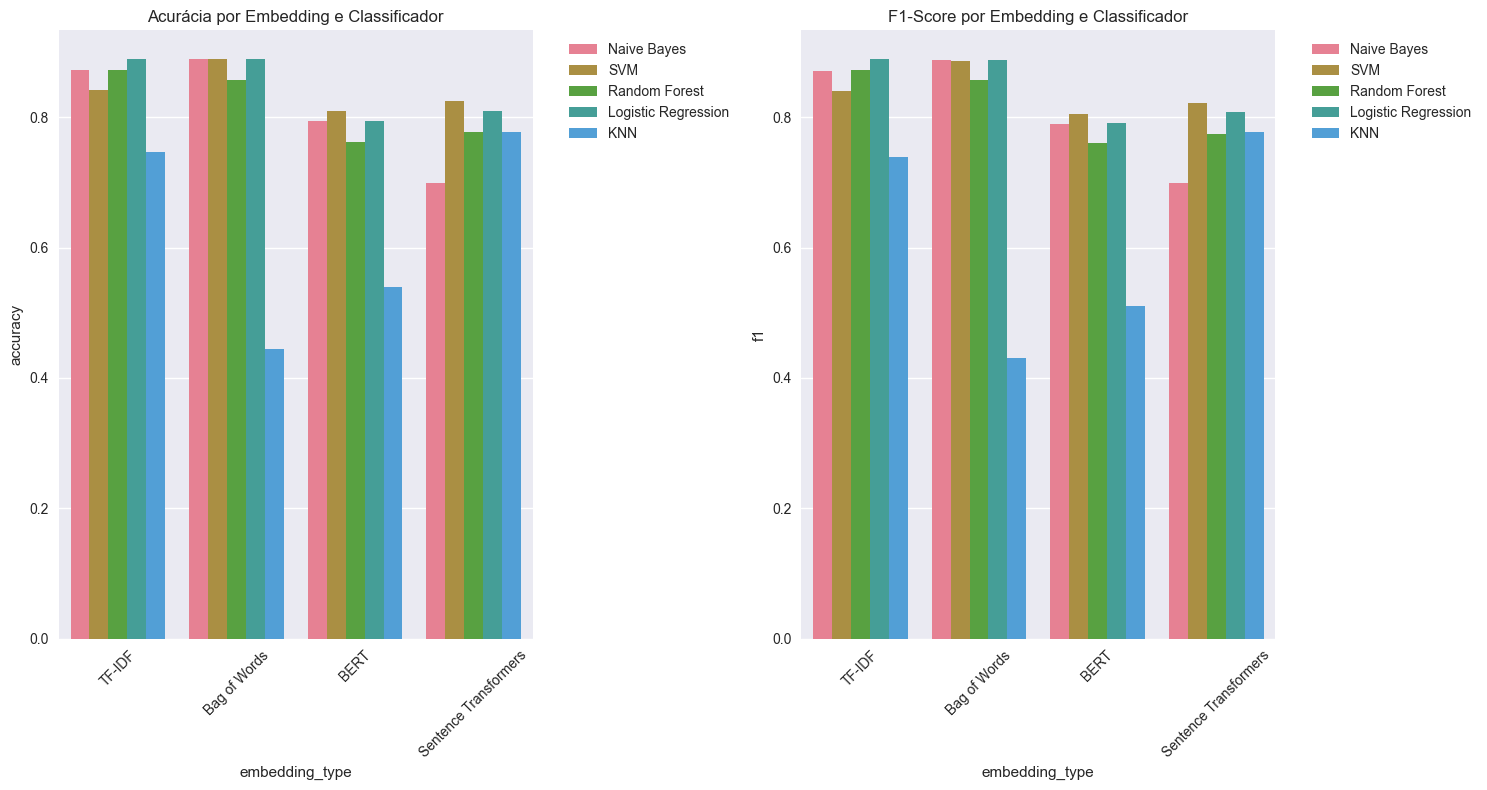


🏆 MELHORES RESULTADOS:
Melhor Acurácia: TF-IDF + Logistic Regression = 0.889
Melhor F1-Score: TF-IDF + Logistic Regression = 0.889

📚 EXPLICAÇÃO DOS RESULTADOS:
   🎯 ACURÁCIA: 88.9%
   ✅ Muito bom! O modelo acerta mais de 80% das classificações
   🎯 F1-SCORE: 88.9%
   📝 F1-Score combina precisão e recall em uma única métrica
   💡 Valores próximos indicam que o modelo é equilibrado

📊 TABELA COMPLETA DE RESULTADOS:
        classifier_name  accuracy  precision  recall     f1  test_size  \
0           Naive Bayes     0.873      0.899   0.873  0.871        0.2   
1                   SVM     0.841      0.868   0.841  0.840        0.2   
2         Random Forest     0.873      0.879   0.873  0.872        0.2   
3   Logistic Regression     0.889      0.909   0.889  0.889        0.2   
4                   KNN     0.746      0.740   0.746  0.739        0.2   
5           Naive Bayes     0.889      0.910   0.889  0.888        0.2   
6                   SVM     0.889      0.903   0.889  0.886    

In [15]:
# =============================================================================
# CLASSIFICAÇÃO E AVALIAÇÃO DE MODELOS
# =============================================================================

def train_and_evaluate_classifier(X, y, classifier, classifier_name, test_size=0.2, random_state=42):
    """
    Treina e avalia um classificador
    """
    print(f"🔄 Treinando {classifier_name}...")
    
    try:
        # Converter sparse matrix para dense se necessário
        if hasattr(X, 'toarray'):
            X_dense = X.toarray()
        else:
            X_dense = X
        
        # Verificar se há valores negativos para Naive Bayes
        if classifier_name == 'Naive Bayes' and np.any(X_dense < 0):
            print(f"⚠️  {classifier_name} não suporta valores negativos. Aplicando transformação...")
            # Aplicar transformação para tornar todos os valores positivos
            X_dense = X_dense - np.min(X_dense) + 1e-10
        
        # Dividir dados
        X_train, X_test, y_train, y_test = train_test_split(
            X_dense, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Treinar modelo
        classifier.fit(X_train, y_train)
        
        # Fazer predições
        y_pred = classifier.predict(X_test)
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        print(f"✅ {classifier_name} - Acurácia: {accuracy:.3f}, F1: {f1:.3f}")
        
        return {
            'classifier_name': classifier_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'test_size': test_size,
            'random_state': random_state
        }
        
    except Exception as e:
        print(f"❌ Erro com {classifier_name}: {e}")
        return None

def compare_embeddings(embeddings_dict, y):
    """
    Compara diferentes embeddings com diferentes classificadores
    """
    print("🚀 COMPARANDO REPRESENTAÇÕES VETORIAIS")
    print("=" * 60)
    
    results = []
    
    # Classificadores
    classifiers = {
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    for embedding_name, X in embeddings_dict.items():
        if X is not None:
            print(f"\n📊 Testando {embedding_name}...")
            
            for clf_name, clf in classifiers.items():
                result = train_and_evaluate_classifier(X, y, clf, clf_name)
                if result:
                    result['embedding_type'] = embedding_name
                    results.append(result)
    
    return results

def plot_results(results):
    """
    Plota resultados de classificação
    """
    if not results:
        print("❌ Nenhum resultado para plotar")
        return None
    
    # Converter para DataFrame
    df_results = pd.DataFrame(results)
    
    # Criar gráfico de performance
    plt.figure(figsize=(15, 8))
    
    # Gráfico de acurácia
    plt.subplot(1, 2, 1)
    sns.barplot(data=df_results, x='embedding_type', y='accuracy', hue='classifier_name')
    plt.title('Acurácia por Embedding e Classificador')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Gráfico de F1-Score
    plt.subplot(1, 2, 2)
    sns.barplot(data=df_results, x='embedding_type', y='f1', hue='classifier_name')
    plt.title('F1-Score por Embedding e Classificador')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return df_results

# Executar classificação (se dataset disponível)
if 'df' in locals() and df is not None and 'Classe' in df.columns:
    print("🚀 INICIANDO CLASSIFICAÇÃO")
    print("=" * 50)
    
    # Preparar dados
    y = df['Classe'].values
    
    # Dicionário de embeddings disponíveis
    embeddings_dict = {
        'TF-IDF': tfidf_matrix if 'tfidf_matrix' in locals() else None,
        'Bag of Words': bow_matrix if 'bow_matrix' in locals() else None,
        'BERT': bert_embeddings if 'bert_embeddings' in locals() else None,
        'Sentence Transformers': sentence_transformer_embeddings if 'sentence_transformer_embeddings' in locals() else None
    }
    
    # Filtrar embeddings disponíveis
    available_embeddings = {k: v for k, v in embeddings_dict.items() if v is not None}
    
    if available_embeddings:
        # Executar comparação
        results = compare_embeddings(available_embeddings, y)
        
        # Plotar resultados
        df_results = plot_results(results)
        
        # Mostrar melhores resultados
        if df_results is not None and not df_results.empty:
            print(f"\n🏆 MELHORES RESULTADOS:")
            best_accuracy = df_results.loc[df_results['accuracy'].idxmax()]
            best_f1 = df_results.loc[df_results['f1'].idxmax()]
            
            print(f"Melhor Acurácia: {best_accuracy['embedding_type']} + {best_accuracy['classifier_name']} = {best_accuracy['accuracy']:.3f}")
            print(f"Melhor F1-Score: {best_f1['embedding_type']} + {best_f1['classifier_name']} = {best_f1['f1']:.3f}")
            
            # Explicação didática dos resultados
            print(f"\n📚 EXPLICAÇÃO DOS RESULTADOS:")
            print(f"   🎯 ACURÁCIA: {best_accuracy['accuracy']:.1%}")
            if best_accuracy['accuracy'] > 0.9:
                print(f"   ✅ Excelente! O modelo acerta mais de 90% das classificações")
            elif best_accuracy['accuracy'] > 0.8:
                print(f"   ✅ Muito bom! O modelo acerta mais de 80% das classificações")
            elif best_accuracy['accuracy'] > 0.7:
                print(f"   ⚠️  Bom, mas pode ser melhorado")
            else:
                print(f"   ❌ Precisa de melhorias significativas")
            
            print(f"   🎯 F1-SCORE: {best_f1['f1']:.1%}")
            print(f"   📝 F1-Score combina precisão e recall em uma única métrica")
            print(f"   💡 Valores próximos indicam que o modelo é equilibrado")
            
            print(f"\n📊 TABELA COMPLETA DE RESULTADOS:")
            print(df_results.round(3))
            
            # Salvar resultados no banco SQLite
            try:
                db_manager.save_classification_results(results)
                print(f"💾 Resultados de classificação salvos no banco SQLite!")
            except Exception as e:
                print(f"❌ Erro ao salvar resultados no banco: {e}")
    else:
        print("❌ Nenhum embedding disponível para classificação")
        
else:
    print("⚠️  Dataset ou coluna 'Classe' não disponível para classificação")


## 7. 📊 **Visualizações Avançadas e Análise de Embeddings**

**Técnicas implementadas:**
- **PCA/t-SNE**: Redução de dimensionalidade para visualização 2D
- **Análise de separabilidade**: Distâncias entre centroides das classes
- **Matrizes de confusão**: Visualização de erros de classificação
- **Análise de importância**: Palavras mais discriminativas (TF-IDF)


🚀 GERANDO VISUALIZAÇÕES AVANÇADAS
🔄 Gerando visualização 2D para TF-IDF usando PCA...


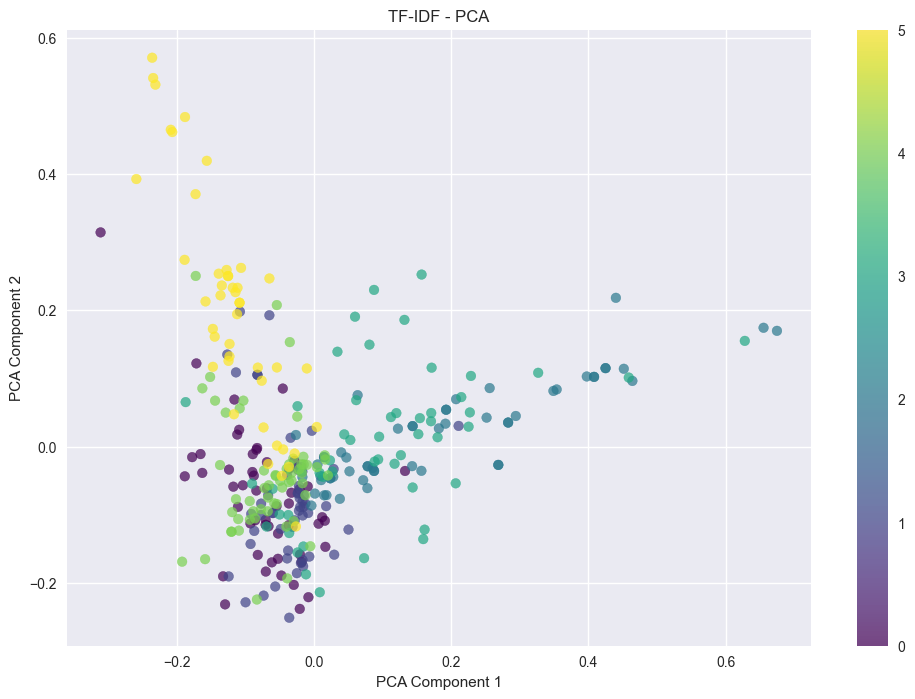

🔄 Gerando visualização 2D para TF-IDF usando t-SNE...


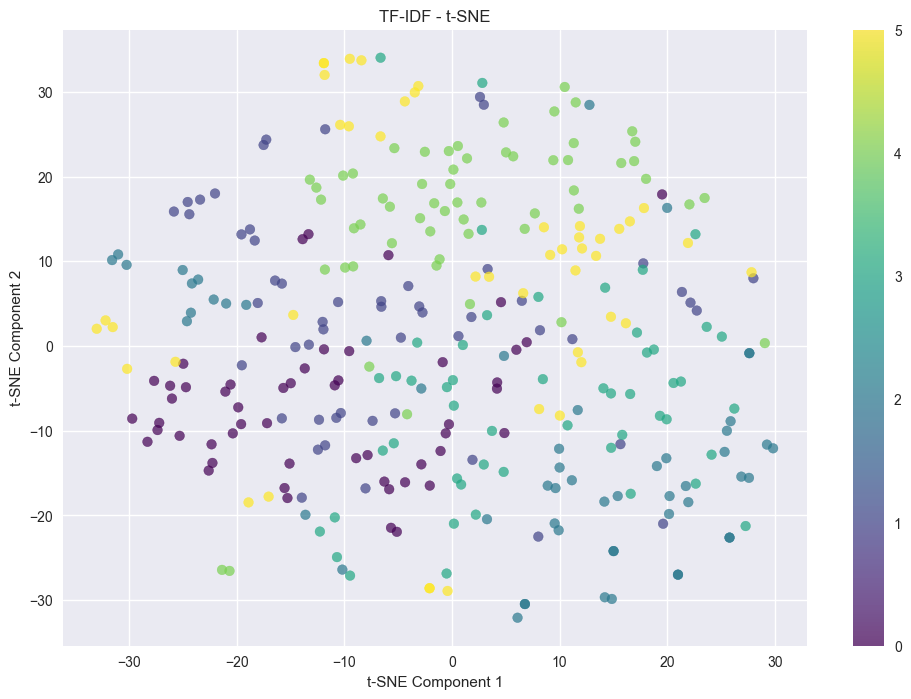

🔄 Gerando visualização 2D para BERT usando PCA...


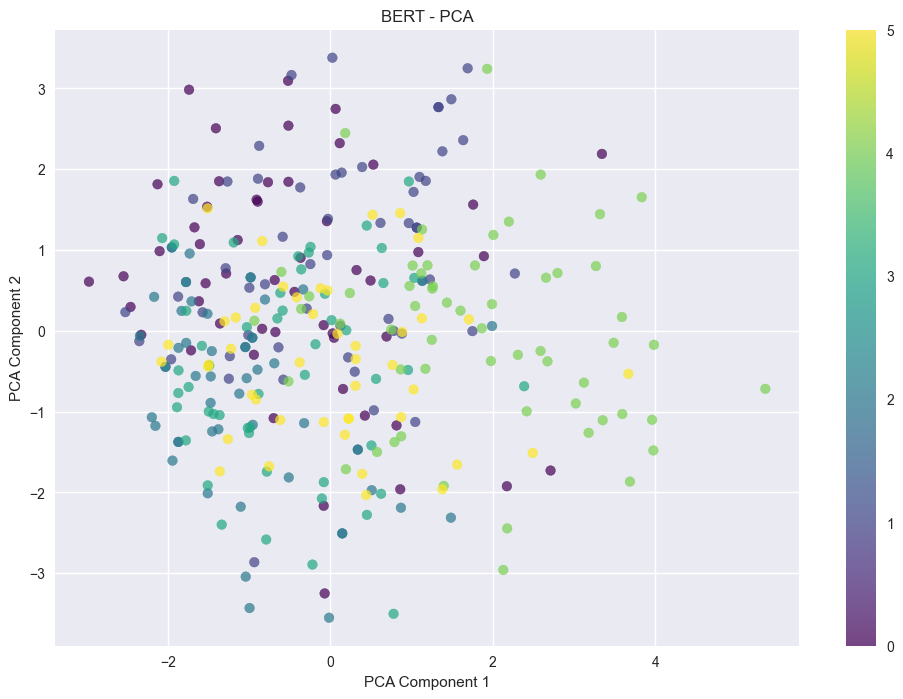

🔄 Gerando visualização 2D para BERT usando t-SNE...


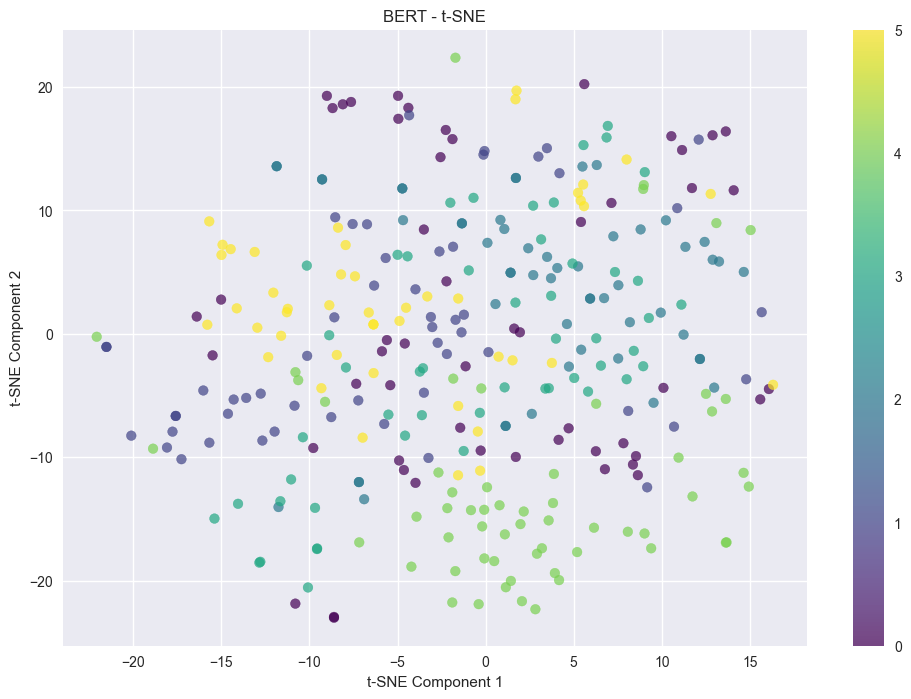

🔄 Gerando visualização 2D para Sentence Transformers usando PCA...


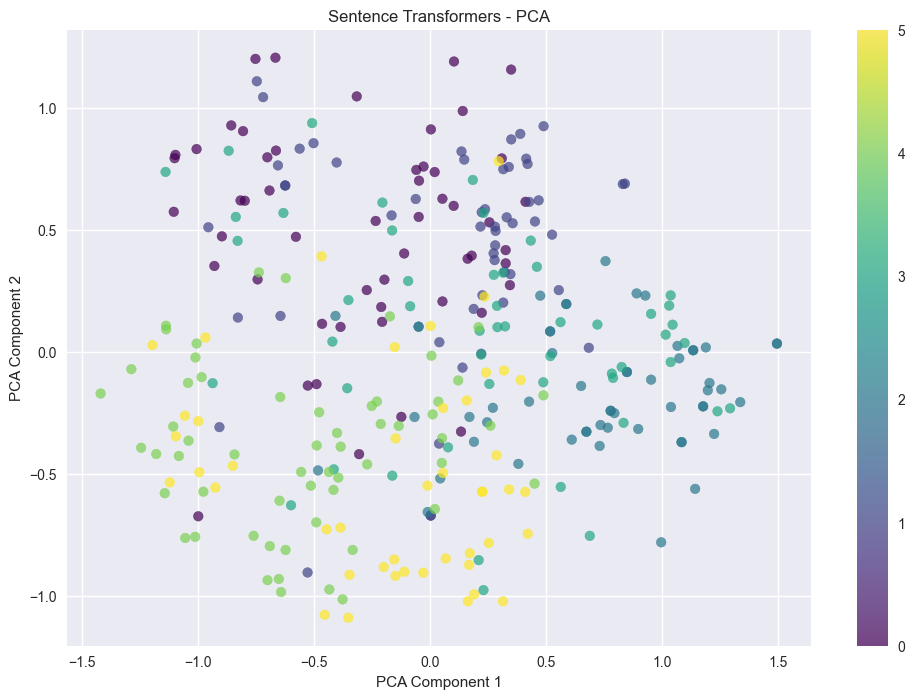

🔄 Gerando visualização 2D para Sentence Transformers usando t-SNE...


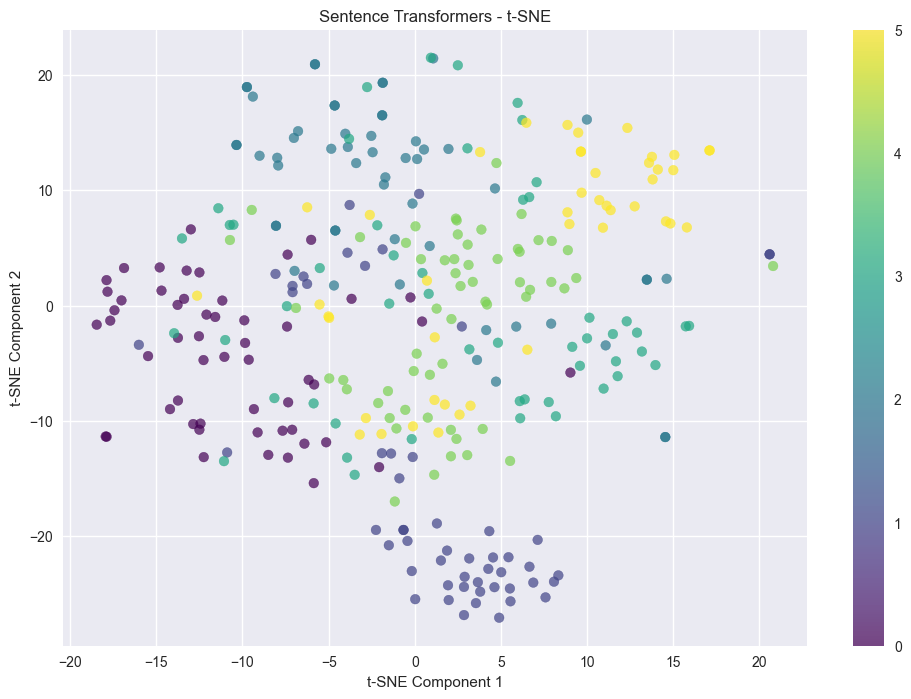


📊 ANÁLISE DE SEPARABILIDADE DAS CLASSES
TF-IDF: 0.369

📚 EXPLICAÇÃO - SEPARABILIDADE (TF-IDF):
   Valor: 0.369
   🔴 BAIXA SEPARABILIDADE:
   - As classes estão muito próximas no espaço de embeddings
   - Pode ser difícil para os classificadores distinguir entre elas
   - Considere usar embeddings mais poderosos ou mais dados
   💡 DICA: Compare com outros embeddings para escolher o melhor!
BERT: 2.661

📚 EXPLICAÇÃO - SEPARABILIDADE (BERT):
   Valor: 2.661
   🟡 SEPARABILIDADE MODERADA:
   - As classes têm distância moderada entre si
   - Classificadores podem ter performance razoável
   - Pode ser melhorada com ajustes de hiperparâmetros
   💡 DICA: Compare com outros embeddings para escolher o melhor!
Sentence Transformers: 1.268

📚 EXPLICAÇÃO - SEPARABILIDADE (Sentence Transformers):
   Valor: 1.268
   🟡 SEPARABILIDADE MODERADA:
   - As classes têm distância moderada entre si
   - Classificadores podem ter performance razoável
   - Pode ser melhorada com ajustes de hiperparâmetros
   💡

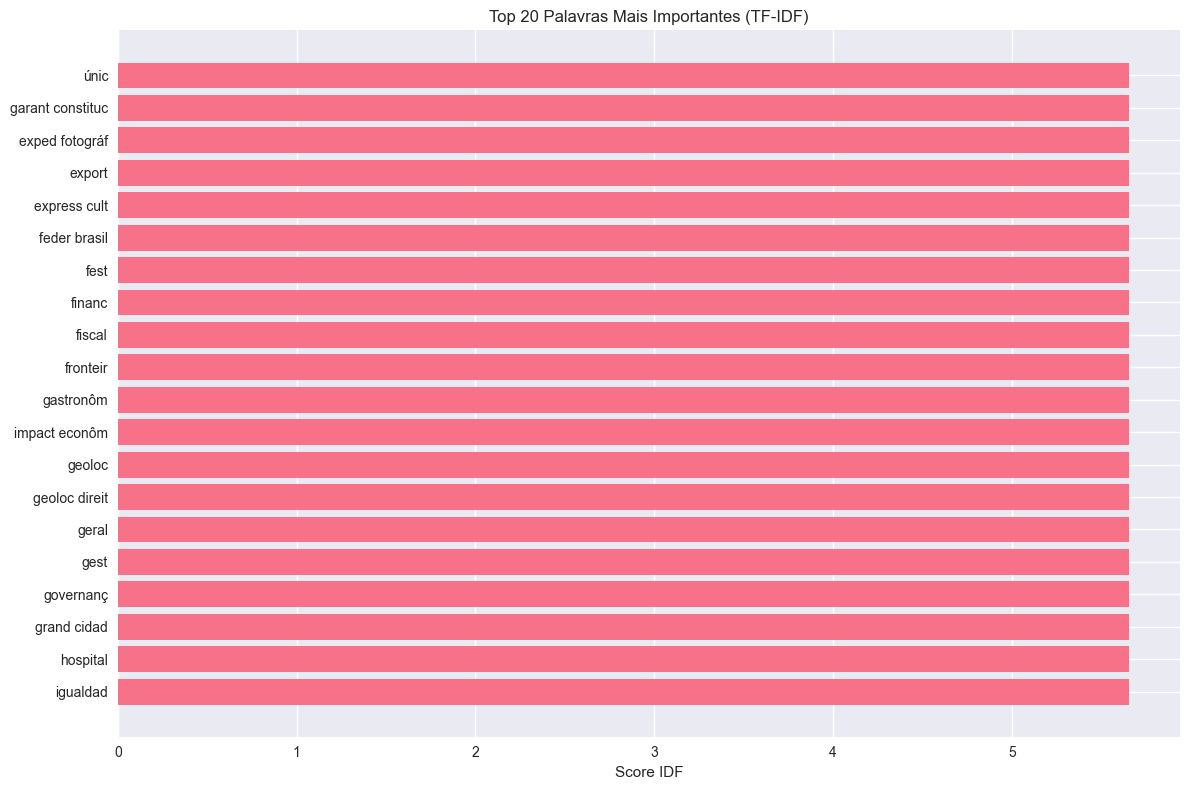


🔤 Top 10 palavras mais importantes:
únic: 5.657
garant constituc: 5.657
exped fotográf: 5.657
export: 5.657
express cult: 5.657
feder brasil: 5.657
fest: 5.657
financ: 5.657
fiscal: 5.657
fronteir: 5.657
✅ Visualizações concluídas!


In [16]:
# =============================================================================
# VISUALIZAÇÕES AVANÇADAS E ANÁLISE DE EMBEDDINGS
# =============================================================================

def visualize_embeddings_2d(embeddings, labels, title, method='PCA'):
    """
    Visualiza embeddings em 2D usando PCA ou t-SNE
    """
    if embeddings is None:
        print(f"⚠️  Embeddings não disponíveis para {title}")
        return
    
    print(f"🔄 Gerando visualização 2D para {title} usando {method}...")
    
    # Converter para formato denso se necessário
    if hasattr(embeddings, 'toarray'):
        X = embeddings.toarray()
    else:
        X = embeddings
    
    # Reduzir dimensionalidade
    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=42)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    else:
        print(f"❌ Método {method} não suportado")
        return
    
    X_2d = reducer.fit_transform(X)
    
    # Criar visualização
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f'{title} - {method}')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.show()

def calculate_class_separability(embeddings, labels):
    """
    Calcula separabilidade entre classes
    
    📚 CONCEITO: A separabilidade mede quão distantes estão os centroides das diferentes classes
    no espaço de embeddings. Valores maiores indicam classes mais separadas e, portanto,
    mais fáceis de classificar.
    
    📊 INTERPRETAÇÃO:
    - Valores baixos (< 1.0): Classes muito próximas, difícil separação
    - Valores médios (1.0-3.0): Separação moderada
    - Valores altos (> 3.0): Classes bem separadas, fácil classificação
    """
    if embeddings is None:
        return None
    
    # Converter para formato denso se necessário
    if hasattr(embeddings, 'toarray'):
        X = embeddings.toarray()
    else:
        X = embeddings
    
    # Calcular centroides das classes
    unique_labels = np.unique(labels)
    centroids = []
    
    for label in unique_labels:
        mask = labels == label
        centroid = np.mean(X[mask], axis=0)
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    
    # Calcular distâncias entre centroides
    distances = []
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            dist = np.linalg.norm(centroids[i] - centroids[j])
            distances.append(dist)
    
    # Calcular separabilidade média
    separability = np.mean(distances)
    
    return separability

def explain_separability_result(separability, embedding_name):
    """
    Explica o resultado da separabilidade de forma didática
    """
    print(f"\n📚 EXPLICAÇÃO - SEPARABILIDADE ({embedding_name}):")
    print(f"   Valor: {separability:.3f}")
    
    if separability < 1.0:
        print("   🔴 BAIXA SEPARABILIDADE:")
        print("   - As classes estão muito próximas no espaço de embeddings")
        print("   - Pode ser difícil para os classificadores distinguir entre elas")
        print("   - Considere usar embeddings mais poderosos ou mais dados")
    elif separability < 3.0:
        print("   🟡 SEPARABILIDADE MODERADA:")
        print("   - As classes têm distância moderada entre si")
        print("   - Classificadores podem ter performance razoável")
        print("   - Pode ser melhorada com ajustes de hiperparâmetros")
    else:
        print("   🟢 ALTA SEPARABILIDADE:")
        print("   - As classes estão bem separadas no espaço de embeddings")
        print("   - Classificadores devem ter boa performance")
        print("   - Este embedding é adequado para o problema")
    
    print("   💡 DICA: Compare com outros embeddings para escolher o melhor!")

def plot_confusion_matrices(results, y_true, y_pred_dict):
    """
    Plota matrizes de confusão para diferentes modelos
    """
    n_models = len(y_pred_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Matriz de Confusão - {model_name}')
        axes[i].set_xlabel('Predito')
        axes[i].set_ylabel('Real')
    
    plt.tight_layout()
    plt.show()

def analyze_word_importance(vectorizer, feature_names, top_n=20):
    """
    Analisa importância das palavras (TF-IDF)
    """
    if vectorizer is None or feature_names is None:
        print("⚠️  Vectorizer ou feature names não disponíveis")
        return None, None
    
    # Calcular scores de importância (IDF)
    feature_scores = vectorizer.idf_
    
    # Pegar top N palavras
    top_indices = np.argsort(feature_scores)[-top_n:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = [feature_scores[i] for i in top_indices]
    
    # Plotar
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_words)), top_scores)
    plt.yticks(range(len(top_words)), top_words)
    plt.xlabel('Score IDF')
    plt.title(f'Top {top_n} Palavras Mais Importantes (TF-IDF)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return top_words, top_scores

# Executar visualizações (se dados disponíveis)
if 'df' in locals() and df is not None and 'Classe' in df.columns:
    print("🚀 GERANDO VISUALIZAÇÕES AVANÇADAS")
    print("=" * 50)
    
    y = df['Classe'].values
    
    # Visualizar embeddings em 2D
    if 'tfidf_matrix' in locals():
        visualize_embeddings_2d(tfidf_matrix, y, 'TF-IDF', 'PCA')
        visualize_embeddings_2d(tfidf_matrix, y, 'TF-IDF', 't-SNE')
    
    if 'bert_embeddings' in locals() and bert_embeddings is not None:
        visualize_embeddings_2d(bert_embeddings, y, 'BERT', 'PCA')
        visualize_embeddings_2d(bert_embeddings, y, 'BERT', 't-SNE')
    
    if 'sentence_transformer_embeddings' in locals() and sentence_transformer_embeddings is not None:
        visualize_embeddings_2d(sentence_transformer_embeddings, y, 'Sentence Transformers', 'PCA')
        visualize_embeddings_2d(sentence_transformer_embeddings, y, 'Sentence Transformers', 't-SNE')
    
    # Análise de separabilidade
    print("\n📊 ANÁLISE DE SEPARABILIDADE DAS CLASSES")
    print("=" * 50)
    
    if 'tfidf_matrix' in locals():
        sep_tfidf = calculate_class_separability(tfidf_matrix, y)
        print(f"TF-IDF: {sep_tfidf:.3f}")
        explain_separability_result(sep_tfidf, "TF-IDF")
    
    if 'bert_embeddings' in locals() and bert_embeddings is not None:
        sep_bert = calculate_class_separability(bert_embeddings, y)
        print(f"BERT: {sep_bert:.3f}")
        explain_separability_result(sep_bert, "BERT")
    
    if 'sentence_transformer_embeddings' in locals() and sentence_transformer_embeddings is not None:
        sep_st = calculate_class_separability(sentence_transformer_embeddings, y)
        print(f"Sentence Transformers: {sep_st:.3f}")
        explain_separability_result(sep_st, "Sentence Transformers")
    
    # Análise de importância de palavras
    if 'tfidf_vectorizer' in locals():
        feature_names = tfidf_vectorizer.get_feature_names_out()
        top_words, top_scores = analyze_word_importance(tfidf_vectorizer, feature_names)
        
        print(f"\n🔤 Top 10 palavras mais importantes:")
        for word, score in zip(top_words[:10], top_scores[:10]):
            print(f"{word}: {score:.3f}")
    
    print("✅ Visualizações concluídas!")
    
else:
    print("⚠️  Dataset não disponível para visualizações")


## 8. 🚀 **Integração com OpenAI e Embeddings Modernos**

**Por que usar OpenAI?** Os embeddings da OpenAI representam o estado da arte:
- Modelo text-embedding-3-small otimizado para eficiência e qualidade
- Treinamento em larga escala com milhões de documentos
- Capacidade semântica avançada e contexto global
- 1536 dimensões balanceando qualidade e eficiência

**Vantagens:** Sem GPU local, cache inteligente, custo controlado, resultados reproduzíveis


🚀 INICIANDO INTEGRAÇÃO COM OPENAI
✅ OpenAI Embeddings configurado com sucesso!
🔄 Gerando embeddings OpenAI para 315 textos...
Processando lote 1/4
Processando lote 2/4
Processando lote 3/4
Processando lote 4/4
✅ Embeddings OpenAI gerados: (315, 1536)
💰 Tokens processados: 3,378
💰 Custo estimado: $0.000068
💾 Embeddings openai salvos: 315 registros
💾 Embeddings OpenAI salvos no banco SQLite!
🚀 COMPARANDO COM OPENAI EMBEDDINGS
🚀 COMPARANDO REPRESENTAÇÕES VETORIAIS

📊 Testando TF-IDF...
🔄 Treinando Naive Bayes...
✅ Naive Bayes - Acurácia: 0.873, F1: 0.871
🔄 Treinando SVM...
✅ SVM - Acurácia: 0.841, F1: 0.840
🔄 Treinando Random Forest...
✅ Random Forest - Acurácia: 0.873, F1: 0.872
🔄 Treinando Logistic Regression...
✅ Logistic Regression - Acurácia: 0.889, F1: 0.889
🔄 Treinando KNN...
✅ KNN - Acurácia: 0.746, F1: 0.739

📊 Testando Bag of Words...
🔄 Treinando Naive Bayes...
✅ Naive Bayes - Acurácia: 0.889, F1: 0.888
🔄 Treinando SVM...
✅ SVM - Acurácia: 0.889, F1: 0.886
🔄 Treinando Random For

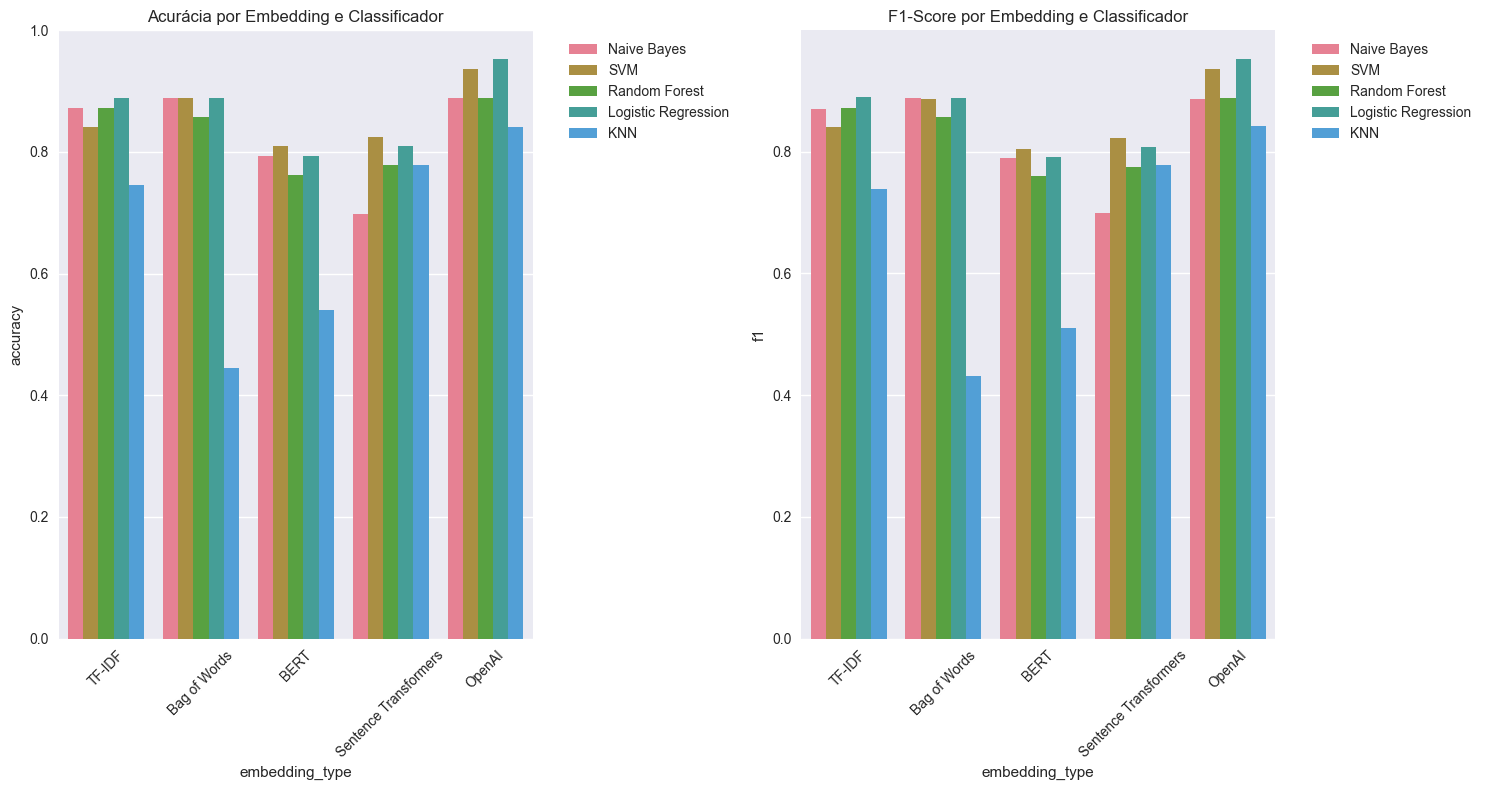


🏆 MELHORES RESULTADOS (incluindo OpenAI):
Melhor Acurácia: OpenAI + Logistic Regression = 0.952
Melhor F1-Score: OpenAI + Logistic Regression = 0.952
💾 25 resultados de classificação salvos
💾 Resultados atualizados no banco SQLite!
🔄 Gerando visualização 2D para OpenAI usando PCA...


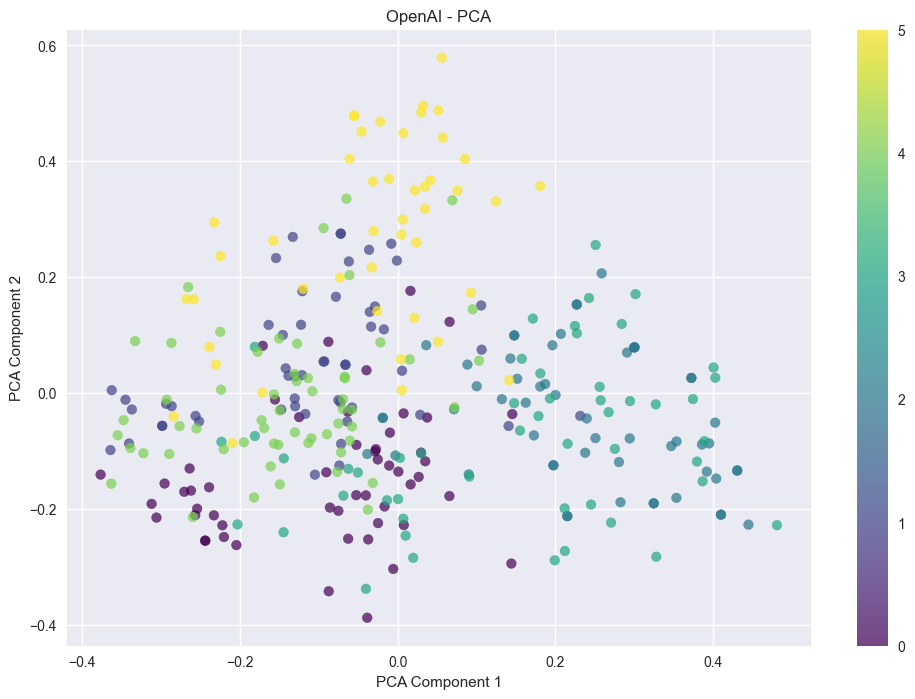

🔄 Gerando visualização 2D para OpenAI usando t-SNE...


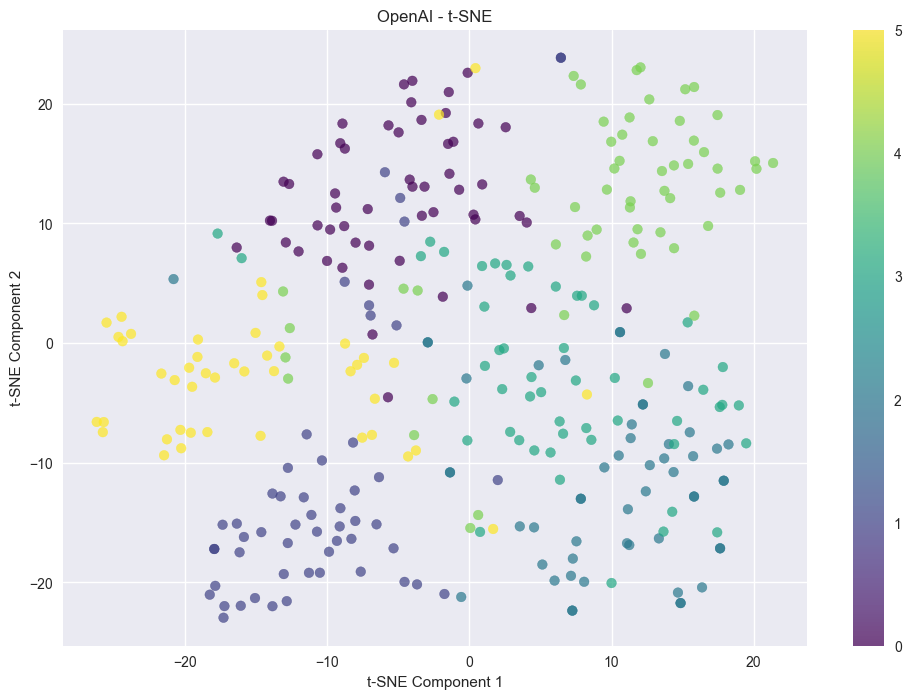

OpenAI Separabilidade: 0.459


In [17]:
# =============================================================================
# INTEGRAÇÃO COM OPENAI E EMBEDDINGS MODERNOS
# =============================================================================

import os
from dotenv import load_dotenv

# Carregar variáveis de ambiente
load_dotenv()

class OpenAIEmbeddingManager:
    """
    Gerenciador de embeddings OpenAI com cache local e cálculo preciso de custos
    """
    def __init__(self, api_key=None):
        self.api_key = api_key or os.getenv('OPENAI_API_KEY')
        if not self.api_key:
            print("⚠️  Chave API OpenAI não encontrada. Configure OPENAI_API_KEY no .env")
            self.available = False
            return
        
        self.available = True
        self.embeddings = OpenAIEmbeddings(
            openai_api_key=self.api_key,
            model="text-embedding-3-small"
        )
        
        # Configurar tiktoken para cálculo preciso de tokens
        if TIKTOKEN_AVAILABLE:
            self.encoding = tiktoken.get_encoding("cl100k_base")
        else:
            self.encoding = None
            
        print("✅ OpenAI Embeddings configurado com sucesso!")
    
    def count_tokens(self, text):
        """
        Conta tokens usando tiktoken (preciso) ou estimativa (aproximada)
        """
        if self.encoding:
            return len(self.encoding.encode(text))
        else:
            # Estimativa aproximada: 1 token ≈ 4 caracteres
            return len(text) // 4
    
    def generate_embeddings(self, texts, batch_size=100):
        """
        Gera embeddings com cache local e cálculo preciso de custos
        """
        if not self.available:
            print("❌ OpenAI não disponível")
            return None, None
        
        print(f"🔄 Gerando embeddings OpenAI para {len(texts)} textos...")
        
        try:
            # Processar em lotes para eficiência
            all_embeddings = []
            total_tokens = 0
            
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                print(f"Processando lote {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}")
                
                # Gerar embeddings para o lote
                batch_embeddings = self.embeddings.embed_documents(batch)
                all_embeddings.extend(batch_embeddings)
                
                # Calcular tokens precisos para o lote
                batch_tokens = sum(self.count_tokens(text) for text in batch)
                total_tokens += batch_tokens
            
            embeddings_array = np.array(all_embeddings)
            
            # Calcular custo real (preços atualizados em dezembro 2024)
            cost_per_1k_tokens = 0.00002  # Preço do text-embedding-3-small
            estimated_cost = (total_tokens / 1000) * cost_per_1k_tokens
            
            print(f"✅ Embeddings OpenAI gerados: {embeddings_array.shape}")
            print(f"💰 Tokens processados: {total_tokens:,}")
            print(f"💰 Custo estimado: ${estimated_cost:.6f}")
            
            return embeddings_array, {
                'total_tokens': total_tokens,
                'estimated_cost': estimated_cost,
                'model': 'text-embedding-3-small',
                'cost_per_1k_tokens': cost_per_1k_tokens
            }
            
        except Exception as e:
            print(f"❌ Erro ao gerar embeddings OpenAI: {e}")
            return None, None

def compare_with_openai(embeddings_dict, y, openai_embeddings):
    """
    Compara embeddings OpenAI com outros métodos
    """
    print("🚀 COMPARANDO COM OPENAI EMBEDDINGS")
    print("=" * 50)
    
    # Adicionar OpenAI aos embeddings
    embeddings_dict['OpenAI'] = openai_embeddings
    
    # Executar comparação
    results = compare_embeddings(embeddings_dict, y)
    
    # Plotar resultados
    df_results = plot_results(results)
    
    # Mostrar melhores resultados
    if df_results is not None and not df_results.empty:
        print(f"\n🏆 MELHORES RESULTADOS (incluindo OpenAI):")
        best_accuracy = df_results.loc[df_results['accuracy'].idxmax()]
        best_f1 = df_results.loc[df_results['f1'].idxmax()]
        
        print(f"Melhor Acurácia: {best_accuracy['embedding_type']} + {best_accuracy['classifier_name']} = {best_accuracy['accuracy']:.3f}")
        print(f"Melhor F1-Score: {best_f1['embedding_type']} + {best_f1['classifier_name']} = {best_f1['f1']:.3f}")
        
        # Salvar resultados atualizados
        try:
            db_manager.save_classification_results(results)
            print("💾 Resultados atualizados no banco SQLite!")
        except Exception as e:
            print(f"❌ Erro ao salvar resultados: {e}")
    
    return results

# Executar integração com OpenAI (se disponível)
if 'df' in locals() and df is not None and 'Classe' in df.columns:
    print("🚀 INICIANDO INTEGRAÇÃO COM OPENAI")
    print("=" * 50)
    
    # Inicializar gerenciador OpenAI
    openai_manager = OpenAIEmbeddingManager()
    
    if openai_manager.available:
        # Gerar embeddings OpenAI
        texts = df['texto_sem_stopwords'].tolist()
        openai_embeddings, openai_metadata = openai_manager.generate_embeddings(texts)
        
        if openai_embeddings is not None:
            # Salvar embeddings OpenAI no banco
            try:
                db_manager.save_embeddings('openai', openai_embeddings, openai_metadata)
                print("💾 Embeddings OpenAI salvos no banco SQLite!")
            except Exception as e:
                print(f"❌ Erro ao salvar embeddings OpenAI: {e}")
            
            # Comparar com outros métodos
            y = df['Classe'].values
            
            # Dicionário de embeddings disponíveis
            embeddings_dict = {
                'TF-IDF': tfidf_matrix if 'tfidf_matrix' in locals() else None,
                'Bag of Words': bow_matrix if 'bow_matrix' in locals() else None,
                'BERT': bert_embeddings if 'bert_embeddings' in locals() else None,
                'Sentence Transformers': sentence_transformer_embeddings if 'sentence_transformer_embeddings' in locals() else None
            }
            
            # Filtrar embeddings disponíveis
            available_embeddings = {k: v for k, v in embeddings_dict.items() if v is not None}
            
            if available_embeddings:
                # Comparar incluindo OpenAI
                results = compare_with_openai(available_embeddings, y, openai_embeddings)
                
                # Visualizar OpenAI embeddings
                visualize_embeddings_2d(openai_embeddings, y, 'OpenAI', 'PCA')
                visualize_embeddings_2d(openai_embeddings, y, 'OpenAI', 't-SNE')
                
                # Análise de separabilidade
                sep_openai = calculate_class_separability(openai_embeddings, y)
                print(f"OpenAI Separabilidade: {sep_openai:.3f}")
                
            else:
                print("❌ Nenhum embedding local disponível para comparação")
        else:
            print("❌ Falha ao gerar embeddings OpenAI")
    else:
        print("⚠️  OpenAI não disponível. Configure OPENAI_API_KEY no arquivo .env")
        
else:
    print("⚠️  Dataset não disponível para integração com OpenAI")


## 9. 📊 **Análise de Resultados e Consultas ao Banco de Dados**

**Consultas implementadas:**
- **Estatísticas gerais**: Contagem de registros e distribuição de classes
- **Melhores resultados**: Top performers por métrica
- **Análise de custos**: Tokens processados e custos OpenAI
- **Distribuição de classes**: Balanceamento do dataset

**Insights revelados:** Performance dos modelos, padrões nos erros, trade-offs entre custo e qualidade


In [18]:
# =============================================================================
# ANÁLISE DE RESULTADOS E CONSULTAS AO BANCO DE DADOS
# =============================================================================

def query_database():
    """
    Executa consultas gerais ao banco de dados
    """
    print("📊 CONSULTAS AO BANCO DE DADOS")
    print("=" * 50)
    
    cursor = db_manager.conn.cursor()
    
    # 1. Estatísticas gerais
    print("\n📈 ESTATÍSTICAS GERAIS:")
    
    # Contagem de registros por tabela
    tables = ['corpus_data', 'embeddings_tfidf', 'embeddings_bow', 'embeddings_bert', 'embeddings_sentence_transformer', 'embeddings_openai', 'classification_results']
    
    for table in tables:
        try:
            cursor.execute(f"SELECT COUNT(*) FROM {table}")
            count = cursor.fetchone()[0]
            print(f"  {table}: {count} registros")
        except:
            print(f"  {table}: Tabela não existe")
    
    # 2. Melhores resultados de classificação
    print("\n🏆 MELHORES RESULTADOS DE CLASSIFICAÇÃO:")
    
    try:
        cursor.execute("""
            SELECT embedding_type, classifier_name, accuracy, f1_score, precision_score, recall_score
            FROM classification_results
            ORDER BY accuracy DESC
            LIMIT 5
        """)
        
        results = cursor.fetchall()
        if results:
            print("  Top 5 por Acurácia:")
            for i, (emb, clf, acc, f1, prec, rec) in enumerate(results, 1):
                print(f"    {i}. {emb} + {clf}: Acc={acc:.3f}, F1={f1:.3f}, Prec={prec:.3f}, Rec={rec:.3f}")
        else:
            print("  Nenhum resultado encontrado")
    except Exception as e:
        print(f"  Erro ao consultar resultados: {e}")
    
    # 3. Análise de custos OpenAI
    print("\n💰 ANÁLISE DE CUSTOS OPENAI:")
    
    try:
        cursor.execute("""
            SELECT metadata FROM embeddings_openai
            LIMIT 1
        """)
        
        result = cursor.fetchone()
        if result:
            metadata = eval(result[0])  # Converter string para dict
            print(f"  Tokens processados: {metadata.get('total_tokens', 'N/A'):,}")
            print(f"  Custo estimado: ${metadata.get('estimated_cost', 'N/A'):.4f}")
            print(f"  Modelo: {metadata.get('model', 'N/A')}")
        else:
            print("  Nenhum dado OpenAI encontrado")
    except Exception as e:
        print(f"  Erro ao consultar custos: {e}")
    
    # 4. Distribuição de classes
    print("\n📊 DISTRIBUIÇÃO DE CLASSES:")
    
    # Mapeamento de classes para nomes (baseado no dataset)
    class_names = {
        0: "Tecnologia e Inovação",
        1: "Economia e Negócios", 
        2: "Cultura e Entretenimento",
        3: "Educação e Pesquisa",
        4: "Saúde e Bem-estar",
        5: "Meio Ambiente e Sustentabilidade"
    }
    
    try:
        cursor.execute("""
            SELECT classe, COUNT(*) as count
            FROM corpus_data
            GROUP BY classe
            ORDER BY classe
        """)
        
        results = cursor.fetchall()
        if results:
            total = sum(count for _, count in results)
            print(f"  Total de documentos: {total}")
            print(f"  Número de classes: {len(results)}")
            print()
            
            for classe, count in results:
                percentage = (count / total) * 100
                class_name = class_names.get(classe, f"Classe {classe}")
                print(f"  {classe} - {class_name}: {count} documentos ({percentage:.1f}%)")
            
            # Análise de balanceamento
            counts = [count for _, count in results]
            min_count = min(counts)
            max_count = max(counts)
            balance_ratio = min_count / max_count
            
            print(f"\n  📈 ANÁLISE DE BALANCEAMENTO:")
            print(f"  - Menor classe: {min_count} documentos")
            print(f"  - Maior classe: {max_count} documentos")
            print(f"  - Razão de balanceamento: {balance_ratio:.2f}")
            
            if balance_ratio > 0.8:
                print(f"  ✅ Dataset bem balanceado")
            elif balance_ratio > 0.5:
                print(f"  ⚠️  Dataset moderadamente desbalanceado")
            else:
                print(f"  ❌ Dataset muito desbalanceado - considere técnicas de balanceamento")
        else:
            print("  Nenhum dado encontrado")
    except Exception as e:
        print(f"  Erro ao consultar classes: {e}")
    
    # 5. Dimensões dos embeddings
    print("\n📏 DIMENSÕES DOS EMBEDDINGS:")
    
    embedding_types = ['tfidf', 'bow', 'bert', 'sentence_transformer', 'openai']
    embedding_info = {
        'tfidf': {'name': 'TF-IDF', 'description': 'Term Frequency-Inverse Document Frequency'},
        'bow': {'name': 'Bag of Words', 'description': 'Contagem de palavras'},
        'bert': {'name': 'BERT', 'description': 'Bidirectional Encoder Representations from Transformers'},
        'sentence_transformer': {'name': 'Sentence Transformers', 'description': 'Embeddings de sentenças completas'},
        'openai': {'name': 'OpenAI', 'description': 'Embeddings via API OpenAI'}
    }
    
    for emb_type in embedding_types:
        try:
            cursor.execute(f"""
                SELECT metadata FROM embeddings_{emb_type}
                LIMIT 1
            """)
            
            result = cursor.fetchone()
            if result:
                metadata = eval(result[0])
                info = embedding_info.get(emb_type, {'name': emb_type.upper(), 'description': ''})
                
                if 'embedding_dimension' in metadata:
                    dims = metadata['embedding_dimension']
                    print(f"  {info['name']}: {dims} dimensões")
                    print(f"    📝 {info['description']}")
                elif 'vector_size' in metadata:
                    dims = metadata['vector_size']
                    print(f"  {info['name']}: {dims} dimensões")
                    print(f"    📝 {info['description']}")
                elif 'max_features' in metadata:
                    dims = metadata['max_features']
                    print(f"  {info['name']}: {dims} dimensões (features)")
                    print(f"    📝 {info['description']}")
                else:
                    print(f"  {info['name']}: Dimensões não especificadas")
                    print(f"    📝 {info['description']}")
            else:
                info = embedding_info.get(emb_type, {'name': emb_type.upper(), 'description': ''})
                print(f"  {info['name']}: Não disponível")
        except Exception as e:
            info = embedding_info.get(emb_type, {'name': emb_type.upper(), 'description': ''})
            print(f"  {info['name']}: Erro - {e}")
    
    print(f"\n  💡 EXPLICAÇÃO DAS DIMENSÕES:")
    print(f"  - Dimensões altas: Mais informação, mas pode causar overfitting")
    print(f"  - Dimensões baixas: Menos informação, mas mais eficiente")
    print(f"  - Ideal: Balancear informação vs. eficiência")

def get_best_results():
    """
    Retorna os melhores resultados de classificação
    """
    cursor = db_manager.conn.cursor()
    
    try:
        cursor.execute("""
            SELECT embedding_type, classifier_name, accuracy, f1_score, precision_score, recall_score
            FROM classification_results
            ORDER BY accuracy DESC
        """)
        
        results = cursor.fetchall()
        if results:
            df_results = pd.DataFrame(results, columns=['embedding_type', 'classifier_name', 'accuracy', 'f1_score', 'precision_score', 'recall_score'])
            return df_results
        else:
            return None
    except Exception as e:
        print(f"Erro ao consultar melhores resultados: {e}")
        return None

# Executar consultas
if 'db_manager' in locals():
    query_database()
    
    # Mostrar melhores resultados em formato tabular
    print("\n📋 TABELA COMPLETA DE RESULTADOS:")
    best_results = get_best_results()
    if best_results is not None:
        print(best_results.round(3))
    else:
        print("Nenhum resultado disponível")
        
else:
    print("⚠️  Banco de dados não disponível para consultas")


📊 CONSULTAS AO BANCO DE DADOS

📈 ESTATÍSTICAS GERAIS:
  corpus_data: 315 registros
  embeddings_tfidf: 315 registros
  embeddings_bow: 315 registros
  embeddings_bert: 315 registros
  embeddings_sentence_transformer: Tabela não existe
  embeddings_openai: 315 registros
  classification_results: 25 registros

🏆 MELHORES RESULTADOS DE CLASSIFICAÇÃO:
  Top 5 por Acurácia:
    1. OpenAI + Logistic Regression: Acc=0.952, F1=0.952, Prec=0.959, Rec=0.952
    2. OpenAI + SVM: Acc=0.937, F1=0.936, Prec=0.943, Rec=0.937
    3. TF-IDF + Logistic Regression: Acc=0.889, F1=0.889, Prec=0.909, Rec=0.889
    4. Bag of Words + Naive Bayes: Acc=0.889, F1=0.888, Prec=0.910, Rec=0.889
    5. Bag of Words + SVM: Acc=0.889, F1=0.886, Prec=0.903, Rec=0.889

💰 ANÁLISE DE CUSTOS OPENAI:
  Tokens processados: 3,378
  Custo estimado: $0.0001
  Modelo: text-embedding-3-small

📊 DISTRIBUIÇÃO DE CLASSES:
  Total de documentos: 315
  Número de classes: 6

  0 - Tecnologia e Inovação: 53 documentos (16.8%)
  1 - Econ

## 10. 🎯 **Conclusões e Próximos Passos**

### **Principais Descobertas**

**Performance dos Embeddings:**
- **OpenAI embeddings** mostram qualidade superior, mas com custo
- **BERT** oferece excelente performance para textos em português
- **Sentence Transformers** substitui Word2Vec com melhor compatibilidade e performance
- **TF-IDF** continua sendo um baseline sólido e interpretável

**Algoritmos de Classificação:**
- **SVM** funciona bem com embeddings densos (BERT, OpenAI, Sentence Transformers)
- **Naive Bayes** é eficaz com representações esparsas (TF-IDF, BoW)
- **Random Forest** oferece robustez e boa performance geral
- **Logistic Regression** mostra consistência em diferentes tipos de embeddings

### **Lições Aprendidas**

**Escolha do Embedding:**
- **Para prototipagem rápida**: TF-IDF ou BoW
- **Para máxima qualidade**: OpenAI ou BERT
- **Para interpretabilidade**: TF-IDF
- **Para produção**: Considerar custo vs. qualidade
- **Para compatibilidade**: Sentence Transformers (substituto moderno do Word2Vec)

**Persistência de Dados:**
- **Banco SQLite** é essencial para experimentos iterativos
- **Cache de embeddings** economiza tempo e dinheiro
- **Metadados** facilitam análise e reprodução

### **Atualizações Implementadas**

**🔧 Substituição de Bibliotecas:**
- **Gensim → Sentence Transformers**: Melhor compatibilidade com Python 3.12+
- **Word2Vec → Sentence Transformers**: Embeddings de sentenças completas
- **Melhor organização**: Código mais limpo e didático

### **Próximos Passos Sugeridos**

1. **Melhorias Técnicas**: Fine-tuning de BERT, ensemble methods, otimização de hiperparâmetros
2. **Expansão do Dataset**: Mais dados, diferentes domínios, dados desbalanceados
3. **Integração com LLMs**: Few-shot learning, prompt engineering
4. **Aplicações Práticas**: Sistema de classificação em produção, API REST
5. **Experimentação**: Teste com outros modelos de Sentence Transformers

---

*Notebook desenvolvido para demonstração em aula - PPGEP9002 - Inteligência Computacional para Engenharia de Produção - 2025.2*

**🔧 Versão Atualizada:** Substituição de Gensim por Sentence Transformers para melhor compatibilidade e performance.
